# ControlNet for CameraPose Conditioning

!!DISCLAIMER!!

You can ran the import and the skip all the subsection with the SKIP tag

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git accelerate transformers xformers==0.0.26.post1 bitsandbytes

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-4fuu5x64
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-4fuu5x64
  Resolved https://github.com/huggingface/diffusers.git to commit 87b9db644b9034bf316811918722f5e09c676b1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 9.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-

In [1]:
!pip list

In [ ]:
!pip install opencv-python

In [3]:
import pandas as pd
import glob
import os
import numpy as np
import re
from tqdm.notebook import tqdm
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download, hf_hub_url
import json
import gzip

from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split

from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch

import bitsandbytes as bnb
from PIL import Image

import wandb
#wandb.login()

AttributeError: module 'torch' has no attribute 'version'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = "./content/000-000"
data_path = "./content/000-000"
drive_path = "./content/drive/MyDrive/ML4CV_poject/data/000-000"

## Download from source

Download the dataset already rendered from BAAI/Objaverse-Mix

In [ ]:
!pip install huggingface_hub

In [3]:
file_path = "./content/000-000"
drive_path = "./content/drive/MyDrive/ML4CV_poject/data/000-000"

In [4]:
hf_hub_download(repo_id="BAAI/Objaverse-MIX", filename="rendered_images/000-000.7z", repo_type="dataset", local_dir=file_path)

000-000.7z:  30%|###       | 1.41G/4.67G [00:00<?, ?B/s]

'\\content\\000-000\\rendered_images\\000-000.7z'

In [ ]:
!apt-get install p7zip-full
!p7zip -d "/content/000-000/rendered_images/000-000.7z" "/content/000-000"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/000-000/rendered_images/                                           1 file, 4669367606 bytes (4454 MiB)

Extracting archive: /content/000-000/rendered_images/000-000.7z
--
Path = /content/000-000/rendered_images/000-000.7z
Type = 7z
Physical Size = 4669367606
Headers Size = 775142
Method = LZMA2:26
Solid = +
Blocks = 3

  0%      0% 5001           0% 5062 - 000-000/00010d9634f645859d2e252d189b31d5/018.png

In [ ]:
#check that the folder with the zip has been deleted
os.path.isdir("./content/000-000/rendered_images")

True

In [ ]:
os.rmdir("./content/000-000/rendered_images")

In [13]:
#check number of items
len(os.listdir("./content/000-000"))

5002

## Copy data to drive [SKIP]

In [ ]:
#copy to drive
!cp -r "/content/000-000" "/content/drive/MyDrive/ML4CV_poject/data/000-000"

## Create DataFrame [SKIP]

All the data from folder 000-000 have been downloaded and stored on the drive folder.
Now we can import them and create a dataframe, or load directly another one

In [ ]:
#get all the path to all images and camera data [ONLY IF DATAFRAME HAVE NOT BEEN CREATED]
data_path = "/content/000-000"
drive_path = "/content/drive/MyDrive/ML4CV_poject/data/000-000"
data = [["model_id", "image_id", "image_path", "camera_path"]]
for img_path in glob.glob(os.path.join(data_path, "**/*.png"), recursive = True):
  model_id = img_path.split("/")[-2]
  img_id = re.split("[/.]",img_path)[-2]
  param_path = img_path[:-4]+".npy"
  #camera_params = np.load(param_path).flatten()
  data.append([model_id,
                img_id,
                img_path,
                param_path])
print(data[:20])

[['model_id', 'image_id', 'image_path', 'camera_path'], ['630fe4d774bc44bb94cc43ebbe05c796', '019', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/019.png', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/019.npy'], ['630fe4d774bc44bb94cc43ebbe05c796', '015', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/015.png', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/015.npy'], ['630fe4d774bc44bb94cc43ebbe05c796', '016', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/016.png', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/016.npy'], ['630fe4d774bc44bb94cc43ebbe05c796', '020', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/020.png', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/020.npy'], ['630fe4d774bc44bb94cc43ebbe05c796', '018', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/018.png', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/018.npy'], ['630fe4d774bc44bb94cc43ebbe05c796', '014', '/content/000-000/630fe4d774bc44bb94cc43ebbe05c796/014.png', '/co

In [ ]:
#build dataframe
df = pd.DataFrame(np.array(data[1:]), columns = data[0])

In [ ]:
df.head()

model_id image_id  \
0  630fe4d774bc44bb94cc43ebbe05c796      019   
1  630fe4d774bc44bb94cc43ebbe05c796      015   
2  630fe4d774bc44bb94cc43ebbe05c796      016   
3  630fe4d774bc44bb94cc43ebbe05c796      020   
4  630fe4d774bc44bb94cc43ebbe05c796      018   

                                          image_path  \
0  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
1  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
2  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
3  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
4  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   

                                         camera_path  
0  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...  
1  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...  
2  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...  
3  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...  
4  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...

In [ ]:
#load camera params
matrices = np.zeros((df.shape[0],12))
for i,filename in enumerate(tqdm(df['camera_path'])):
  matrices[i,:] = np.load(filename).flatten()

print(matrices.shape)

  0%|          | 0/60000 [00:00<?, ?it/s]

(60000, 12)


In [ ]:
#concat to the other dataframe
camera_df = pd.DataFrame(matrices)
dfs = pd.concat([df,camera_df], axis=1)

In [ ]:
dfs.iloc[:5]

model_id image_id  \
0  630fe4d774bc44bb94cc43ebbe05c796      019   
1  630fe4d774bc44bb94cc43ebbe05c796      015   
2  630fe4d774bc44bb94cc43ebbe05c796      016   
3  630fe4d774bc44bb94cc43ebbe05c796      020   
4  630fe4d774bc44bb94cc43ebbe05c796      018   

                                          image_path  \
0  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
1  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
2  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
3  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
4  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   

                                         camera_path             0         1  \
0  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -5.000001e-01  0.866026   
1  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -2.220446e-16  1.000000   
2  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -1.000000e+00  0.000000   
3  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -5.000001e-01 -0.866026   
4  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...  1.000000e+00  0.000000   

              2             3    4             5         6             7  \
0 -2.660509e-08  3.762528e-08 -0.5 -2.886752e-01  0.816497  2.682209e-07   
1  0.000000e+00  4.440892e-16  0.0 -2.220446e-16  1.000000  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.0 -1.343589e-07  1.000000  2.687177e-07   
3  2.660509e-08 -3.762528e-08  0.5 -2.886752e-01  0.816497  2.682209e-07   
4  0.000000e+00  0.000000e+00  0.0  7.071068e-01  0.707107 -5.960464e-08   

          8         9            10       11  
0  0.707107  0.408248  5.773503e-01 -2.44949  
1  1.000000  0.000000 -2.220446e-16 -2.00000  
2  0.000000  1.000000 -1.343589e-07 -2.00000  
3 -0.707107  0.408248  5.773503e-01 -2.44949  
4  0.000000 -0.707107  7.071068e-01 -2.00000

In [ ]:
#save dfs
dfs.to_csv(data_path+".csv", index = False)

In [ ]:
#save also in drive
!cp "/content/000-000.csv" "/content/drive/MyDrive/ML4CV_poject/data"

## Relative camera position [SKIP]
To make the model more robust, as suggested and used in papers, we would like to have relative camera position instead of absolute one

In [ ]:
df = pd.read_csv(drive_path+".csv", dtype = {'image_id': str})
print(df.shape)
df.head()

(60000, 16)


model_id image_id  \
0  630fe4d774bc44bb94cc43ebbe05c796      019   
1  630fe4d774bc44bb94cc43ebbe05c796      015   
2  630fe4d774bc44bb94cc43ebbe05c796      016   
3  630fe4d774bc44bb94cc43ebbe05c796      020   
4  630fe4d774bc44bb94cc43ebbe05c796      018   

                                          image_path  \
0  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
1  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
2  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
3  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   
4  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...   

                                         camera_path             0         1  \
0  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -5.000001e-01  0.866026   
1  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -2.220446e-16  1.000000   
2  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -1.000000e+00  0.000000   
3  /content/000-000/630fe4d774bc44bb94cc43ebbe05c... -5.000001e-01 -0.866026   
4  /content/000-000/630fe4d774bc44bb94cc43ebbe05c...  1.000000e+00  0.000000   

              2             3    4             5         6             7  \
0 -2.660509e-08  3.762528e-08 -0.5 -2.886752e-01  0.816497  2.682209e-07   
1  0.000000e+00  4.440892e-16  0.0 -2.220446e-16  1.000000  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.0 -1.343589e-07  1.000000  2.687177e-07   
3  2.660509e-08 -3.762528e-08  0.5 -2.886752e-01  0.816497  2.682209e-07   
4  0.000000e+00  0.000000e+00  0.0  7.071068e-01  0.707107 -5.960464e-08   

          8         9            10       11  
0  0.707107  0.408248  5.773503e-01 -2.44949  
1  1.000000  0.000000 -2.220446e-16 -2.00000  
2  0.000000  1.000000 -1.343589e-07 -2.00000  
3 -0.707107  0.408248  5.773503e-01 -2.44949  
4  0.000000 -0.707107  7.071068e-01 -2.00000

In [ ]:
df.dtypes

model_id        object
image_id        object
image_path      object
camera_path     object
0              float64
1              float64
2              float64
3              float64
4              float64
5              float64
6              float64
7              float64
8              float64
9              float64
10             float64
11             float64
dtype: object

Let's visualize some images

model_id:  ef90ce3a7d2a47e99eeef1e94b789e68
image_id:  020


(-0.5, 511.5, 511.5, -0.5)

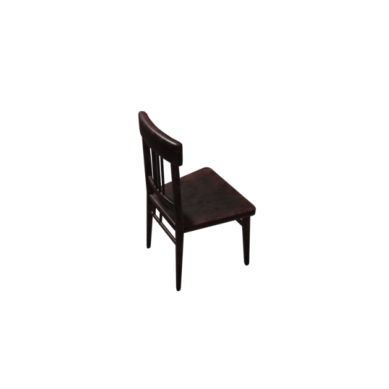

In [ ]:
model_idx = 2272  # @param {type:"slider", min:0, max:4999, step:1}
model_id = df['model_id'].unique()[model_idx]
print("model_id: ",model_id)
image_idx = 3  # @param {type:"slider", min:0, max:11, step:1}
image_id = df[df['model_id'] == model_id]['image_id'].unique()[image_idx]
print("image_id: ",image_id)

img = mpimg.imread(os.path.join(data_path,model_id,image_id+".png"))
plt.imshow(img)
plt.axis('off')

Very hard case images... not a lot of info to use.
Let's preprocess them:

*  for each image we create pairs with another image on the same object in order to learn the realtive rotation instead of absolute one.

Relative camera rotation

Camera of img_1:
$\begin{bmatrix}
   \tilde{x_{1}} \\
   \tilde{y_{1}} \\
   \tilde{z_{1}}
\end{bmatrix}
= R_1
\begin{bmatrix}
    x \\
    y \\
    z
\end{bmatrix}
+ T_1
$

Camera of image_2:
$\begin{bmatrix}
   \tilde{x_{2}} \\
   \tilde{y_{2}} \\
   \tilde{z_{2}}
\end{bmatrix}
= R_2
\begin{bmatrix}
    x \\
    y \\
    z
\end{bmatrix}
+ T_2
$

Relative camera_21:
$\begin{bmatrix}
   \tilde{x_{2}} \\
   \tilde{y_{2}} \\
   \tilde{z_{2}}
\end{bmatrix}
= R_2 R_1^T
\begin{bmatrix}
   \tilde{x_{1}} \\
   \tilde{y_{1}} \\
   \tilde{z_{1}}
\end{bmatrix}
-R_2 R_1^T T_1
+ T_2
$

In [ ]:
def compute_pair (d1, d2, keys_to_remove):
  R1 = np.array([d1[str(i)] for i in range(12)]).reshape(3,4)[:,:3]
  T1 = np.array([d1[str(i)] for i in range(12)]).reshape(3,4)[:,-1]
  R2 = np.array([d2[str(i)] for i in range(12)]).reshape(3,4)[:,:3]
  T2 = np.array([d2[str(i)] for i in range(12)]).reshape(3,4)[:,-1]

  rel_R = np.matmul(np.transpose(R1), R2)
  rel_T = T2-np.matmul(rel_R, T1)
  new_row = {k:v for k,v in d1.items() if k not in keys_to_remove}
  new_row['image_id2'] = d2['image_id']
  new_row['image_path2'] = d2['image_path']
  new_row.update({str(i):x for i,x in enumerate(np.column_stack([rel_R, rel_T]).flatten())})
  return new_row

In [ ]:
from itertools import permutations
def create_pairs(subdf, keys_to_remove):
  return [compute_pair(d1,d2,keys_to_remove) for d1,d2 in permutations(subdf.to_dict('records'),2)]


In [ ]:
#Create new dataframe with the pairs
cols_to_remove = ['camera_path']
pairs = []
for _,subdf in tqdm(df.groupby(['model_id']), total = len(df.groupby(['model_id']))):
  pairs = pairs + create_pairs(subdf, cols_to_remove)

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/tqdm/std.py:1181: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:


In [ ]:
len(pairs)

660000

In [ ]:
rel_df = pd.DataFrame(pairs)

In [ ]:
rel_df.head()

model_id image_id  \
0  000074a334c541878360457c672b6c2e      019   
1  000074a334c541878360457c672b6c2e      019   
2  000074a334c541878360457c672b6c2e      019   
3  000074a334c541878360457c672b6c2e      019   
4  000074a334c541878360457c672b6c2e      019   

                                          image_path         0         1  \
0  /content/000-000/000074a334c541878360457c672b6...  0.707107 -0.500000   
1  /content/000-000/000074a334c541878360457c672b6...  0.500000  0.707107   
2  /content/000-000/000074a334c541878360457c672b6... -0.500000  0.866025   
3  /content/000-000/000074a334c541878360457c672b6... -0.500000 -0.853553   
4  /content/000-000/000074a334c541878360457c672b6... -0.500000 -0.500000   

              2             3         4         5             6             7  \
0 -5.000001e-01 -1.224745e+00  0.408248  0.866025 -2.886752e-01 -7.071072e-01   
1 -5.000003e-01 -1.224746e+00 -0.866026  0.408248 -2.886753e-01 -7.071071e-01   
2 -5.462510e-08 -3.363853e-07 -0.866025 -0.500000 -6.575349e-08  1.898193e-07   
3  1.464465e-01  3.587193e-01  0.866025 -0.492799  8.455088e-02  2.071066e-01   
4  7.071068e-01  1.732051e+00  0.866025 -0.288675  4.082482e-01  1.000000e+00   

              8             9        10            11 image_id2  \
0  5.773503e-01 -1.384282e-10  0.816497 -1.608021e-07       015   
1  1.384281e-10  5.773503e-01  0.816497 -5.399714e-07       016   
2  5.462510e-08 -6.575349e-08  1.000000  1.971452e-08       020   
3 -1.384280e-10  1.691019e-01  0.985599  4.142135e-01       018   
4 -1.384280e-10  8.164966e-01  0.577350 -5.857866e-01       014   

                                         image_path2  
0  /content/000-000/000074a334c541878360457c672b6...  
1  /content/000-000/000074a334c541878360457c672b6...  
2  /content/000-000/000074a334c541878360457c672b6...  
3  /content/000-000/000074a334c541878360457c672b6...  
4  /content/000-000/000074a334c541878360457c672b6...

In [ ]:
print("drive_path: "+drive_path, "data_path: "+data_path)

drive_path: /content/drive/MyDrive/ML4CV_poject/data/000-000 data_path: /content/000-000


In [ ]:
rel_df.to_csv(data_path+"_rel.csv", index = False)

In [ ]:
rel_df.to_csv(drive_path+"_rel.csv", index = False)

## Description Data [SKIP]
Let's add description data

In [ ]:
rel_df = pd.read_csv(drive_path+"_rel.csv", dtype = {'image_id': str, 'image_id2':str})

In [ ]:
rel_df.head()

In [ ]:
hf_hub_download(repo_id="allenai/objaverse", filename="metadata/000-000.json.gz", repo_type="dataset", local_dir=data_path)

000-000.json.gz:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

'/content/000-000/metadata/000-000.json.gz'

In [ ]:
#read the data
with gzip.open(os.path.join(data_path, "metadata/000-000.json.gz"), 'rb') as f:
    metadata = json.loads(f.read())

In [ ]:
#trim usless attributes. We are interested only in tag, categories, description and uid
annotations = []
for uid, x in metadata.items():
  tags = []
  for tag in x['tags']:
    tags.append(tag['name'])
  categories = []
  for cat in x['categories']:
    categories.append(cat['name'])
  name = x['name']
  description = x['description']
  annotations.append({'model_id': uid, 'name': name, 'tags':tags, 'categories':categories, 'description': description})

In [ ]:
annotations[:2]

In [ ]:
#append the new info to the previous dataframe.
annotations = pd.DataFrame(annotations)
rel_df = rel_df.merge(annotations, on = 'model_id')
rel_df.head()

model_id image_id  \
0  000074a334c541878360457c672b6c2e      019   
1  000074a334c541878360457c672b6c2e      019   
2  000074a334c541878360457c672b6c2e      019   
3  000074a334c541878360457c672b6c2e      019   
4  000074a334c541878360457c672b6c2e      019   

                                          image_path         0         1  \
0  /content/000-000/000074a334c541878360457c672b6...  0.707107 -0.500000   
1  /content/000-000/000074a334c541878360457c672b6...  0.500000  0.707107   
2  /content/000-000/000074a334c541878360457c672b6... -0.500000  0.866025   
3  /content/000-000/000074a334c541878360457c672b6... -0.500000 -0.853553   
4  /content/000-000/000074a334c541878360457c672b6... -0.500000 -0.500000   

              2             3         4         5             6  ...  \
0 -5.000001e-01 -1.224745e+00  0.408248  0.866025 -2.886752e-01  ...   
1 -5.000003e-01 -1.224746e+00 -0.866026  0.408248 -2.886753e-01  ...   
2 -5.462510e-08 -3.363853e-07 -0.866025 -0.500000 -6.575349e-08  ...   
3  1.464465e-01  3.587193e-01  0.866025 -0.492799  8.455088e-02  ...   
4  7.071068e-01  1.732051e+00  0.866025 -0.288675  4.082482e-01  ...   

              8             9        10            11  image_id2  \
0  5.773503e-01 -1.384282e-10  0.816497 -1.608021e-07        015   
1  1.384281e-10  5.773503e-01  0.816497 -5.399714e-07        016   
2  5.462510e-08 -6.575349e-08  1.000000  1.971452e-08        020   
3 -1.384280e-10  1.691019e-01  0.985599  4.142135e-01        018   
4 -1.384280e-10  8.164966e-01  0.577350 -5.857866e-01        014   

                                         image_path2            name  \
0  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
1  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
2  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
3  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
4  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   

                                                tags  \
0  [soft, gray, shoes, foam, realistic, beach, sc...   
1  [soft, gray, shoes, foam, realistic, beach, sc...   
2  [soft, gray, shoes, foam, realistic, beach, sc...   
3  [soft, gray, shoes, foam, realistic, beach, sc...   
4  [soft, gray, shoes, foam, realistic, beach, sc...   

                        categories  \
0  [fashion-style, sports-fitness]   
1  [fashion-style, sports-fitness]   
2  [fashion-style, sports-fitness]   
3  [fashion-style, sports-fitness]   
4  [fashion-style, sports-fitness]   

                                         description  
0  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
1  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
2  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
3  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
4  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  

[5 rows x 21 columns]

In [ ]:
rel_df.to_csv(data_path+"_rel.csv", index = False)

In [ ]:
rel_df.to_csv(drive_path+"_rel.csv", index = False)

## Dataset declaration

In [3]:
#create datasets class for our data
from transformers import AutoTokenizer, PretrainedConfig

class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None, channels: int=3, delete_prob: float=0.5):
      tokenizer = AutoTokenizer.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            subfolder="tokenizer",
            revision=None,
            use_fast=False,
        )
      texts = [re.sub("[\[\]]", ' ', str(x)+str(y)+str(z)) for x, y, z in zip(df['tags'], df['categories'], df['description'])]
      self.tokenized = tokenizer(texts, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
      self.df = df
      self.transform = transform
      self.target_transform = target_transform
      self.channels = channels
      self.delete_prob = delete_prob
      self.empty_text = tokenizer('', max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids[0]

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_path = self.df['image_path'].iloc[idx]
        target_img_path = self.df['image_path2'].iloc[idx]
        image = read_image(img_path)
        target_image = read_image(target_img_path)
        image = image[:self.channels, :, :]
        target_image = target_image[:self.channels, :, :]
        if np.random.random() < self.delete_prob:
          label = self.empty_text
        else:
          label = self.tokenized[idx, :]
        camera = self.df[[str(i) for i in range(12)]].iloc[idx].to_numpy().reshape((3,4))
        camera = torch.Tensor(camera)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target_image = self.target_transform(target_image)
        return image, label, camera, target_image

In [4]:
#DATASETS
from torchvision.transforms import v2
resolution = 512
channels = 3

image_transforms = v2.Compose(
    [
        v2.Resize(resolution, interpolation=v2.InterpolationMode.BILINEAR),
        v2.CenterCrop(resolution),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        #v2.Normalize([0.5], [0.5])  #is needed?
    ]
)

conditioning_image_transforms = v2.Compose(
    [
        v2.Resize(resolution, interpolation=v2.InterpolationMode.BILINEAR),
        v2.CenterCrop(resolution),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ]
)

## Load Small or Large Dataset

In [ ]:
##############################
######## READ COMMENT ########
##############################

use_small_split = True

In [ ]:
df = pd.read_csv(drive_path+"_rel.csv", dtype = {'image_id': str, 'image_id2':str, 'description':str}, na_filter = False)

In [ ]:
df.head()

model_id image_id  \
0  000074a334c541878360457c672b6c2e      019   
1  000074a334c541878360457c672b6c2e      019   
2  000074a334c541878360457c672b6c2e      019   
3  000074a334c541878360457c672b6c2e      019   
4  000074a334c541878360457c672b6c2e      019   

                                          image_path         0         1  \
0  /content/000-000/000074a334c541878360457c672b6...  0.707107 -0.500000   
1  /content/000-000/000074a334c541878360457c672b6...  0.500000  0.707107   
2  /content/000-000/000074a334c541878360457c672b6... -0.500000  0.866025   
3  /content/000-000/000074a334c541878360457c672b6... -0.500000 -0.853553   
4  /content/000-000/000074a334c541878360457c672b6... -0.500000 -0.500000   

              2             3         4         5             6  ...  \
0 -5.000001e-01 -1.224745e+00  0.408248  0.866025 -2.886752e-01  ...   
1 -5.000003e-01 -1.224746e+00 -0.866026  0.408248 -2.886753e-01  ...   
2 -5.462510e-08 -3.363853e-07 -0.866025 -0.500000 -6.575349e-08  ...   
3  1.464465e-01  3.587193e-01  0.866025 -0.492799  8.455088e-02  ...   
4  7.071068e-01  1.732051e+00  0.866025 -0.288675  4.082482e-01  ...   

              8             9        10            11  image_id2  \
0  5.773503e-01 -1.384282e-10  0.816497 -1.608021e-07        015   
1  1.384281e-10  5.773503e-01  0.816497 -5.399714e-07        016   
2  5.462510e-08 -6.575349e-08  1.000000  1.971452e-08        020   
3 -1.384280e-10  1.691019e-01  0.985599  4.142135e-01        018   
4 -1.384280e-10  8.164966e-01  0.577350 -5.857866e-01        014   

                                         image_path2            name  \
0  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
1  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
2  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
3  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   
4  /content/000-000/000074a334c541878360457c672b6...  Worn Flip Flop   

                                                tags  \
0  ['soft', 'gray', 'shoes', 'foam', 'realistic',...   
1  ['soft', 'gray', 'shoes', 'foam', 'realistic',...   
2  ['soft', 'gray', 'shoes', 'foam', 'realistic',...   
3  ['soft', 'gray', 'shoes', 'foam', 'realistic',...   
4  ['soft', 'gray', 'shoes', 'foam', 'realistic',...   

                            categories  \
0  ['fashion-style', 'sports-fitness']   
1  ['fashion-style', 'sports-fitness']   
2  ['fashion-style', 'sports-fitness']   
3  ['fashion-style', 'sports-fitness']   
4  ['fashion-style', 'sports-fitness']   

                                         description  
0  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
1  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
2  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
3  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  
4  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...  

[5 rows x 21 columns]

In [ ]:
#SPLITS
train_df, test_df = train_test_split(df, test_size=.2, random_state=420)
train_df, val_df = train_test_split(train_df, test_size=.3, random_state=420)
if use_small_split:
  small_df, train_df = train_test_split(train_df, test_size=.99, random_state=420)
print(f"train_df: {train_df.shape}, val_df:{val_df.shape}, test_df: {test_df.shape}, small_df: {small_df.shape}")


train_df: (365904, 30), val_df:(158400, 30), test_df: (132000, 30), small_df: (3696, 30)


In [ ]:
if not use_small_split:
  train_dataset = CustomImageDataset(train_df, transform = image_transforms, target_transform = conditioning_image_transforms, channels=channels)
  val_dataset = CustomImageDataset(val_df, transform = ToTensor(), target_transform=ToTensor(), channels=channels)
  test_dataset = CustomImageDataset(test_df, transform = ToTensor(), target_transform=ToTensor(), channels=channels)
else:
  train_dataset = CustomImageDataset(small_df, transform = image_transforms, target_transform = conditioning_image_transforms, channels=channels)

In [ ]:
#testing
image1, label, camera, image2 = train_dataset.__getitem__(50)
image1.shape

torch.Size([3, 512, 512])

Label:  tensor([49406,   262,  3272,  5662,   262,  3420,  5662,   568,  1260,   554,
         1252,  5662,   568,  4350,  5662,   262, 14317,  5662,   262,  6469,
          262,   262,  6564,   268, 13938,  5662,   262,  1047,   262,   320,
         1167,   539,  2463,  6433,  3095,   267,   265,   722,   835,  1059,
          531,  3794,   537,  8013,   531,  2478,  4121,   679,    69,  1553,
        26145, 14850,   281,   268,   279,  3095,   268, 13690, 16505, 12744,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])
Camera:  tensor([[ 0.5000,  0.2887, -0.8165, -2.0000],
        [ 0.2887,  0.8333,  0.4714,  1.1547],
        [ 0.8165, -0.4714,  0.3333, -1.6330]])
<class 'torchvision.tv_tensors._image.Image'>


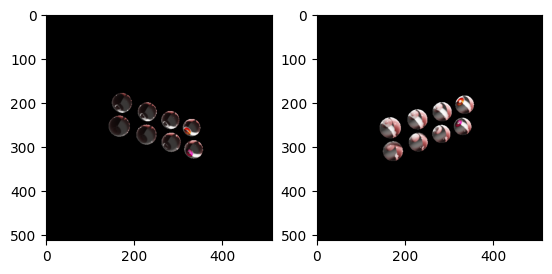

In [ ]:
image1, label, camera, image2 = train_dataset.__getitem__(50)
print('Label: ', label)
print('Camera: ', camera)
print(type(image1))
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(  image1.permute(1, 2, 0)  )
fig.add_subplot(1, 2, 2)
plt.imshow(  image2.permute(1, 2, 0)  )
plt.show()

### Cleaning df by CLIP score [SKIP]

I will use this small subsection to try this stuff out

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
url = 'https://www.magicmurals.com/media/amasty/webp/catalog/product/cache/155d73b570b90ded8a140526fcb8f2da/d/p/dpx-0001975184_jpg.webp'
image = Image.open(requests.get(url, stream=True).raw)

prompts = ['a picture of a turtle',
           'a picture of a turtle peacefully swimming in the sea',
           'a picture of a turtle peacefully swimming in the sea, you can see algae on the ocean floor',
           'a picture of an acquatic animal',
           'a picture of a crustacean', # Noice! Turtles are not crustaceans! Model scores this at 22.9915828704834
           'a picture of a reptile', # They are, in fact, reptiles and the model gives it a score of 25.321945190429688
           'a picture of me taking a shower', # Don't worry I didn't hide picture of me taking a shower inside this notebook (maybe)
           'a picture of me driving a car',
           'a picture of a cat playing with a plush']

inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image

pd.DataFrame(list(zip(prompts, logits_per_image[0])), columns=['Prompt', 'CLIP Logit'])

Prompt  \
0                              a picture of a turtle   
1  a picture of a turtle peacefully swimming in t...   
2  a picture of a turtle peacefully swimming in t...   
3                    a picture of an acquatic animal   
4                          a picture of a crustacean   
5                             a picture of a reptile   
6                    a picture of me taking a shower   
7                      a picture of me driving a car   
8            a picture of a cat playing with a plush   

                                   CLIP Logit  
0  tensor(29.5193, grad_fn=<UnbindBackward0>)  
1  tensor(29.8239, grad_fn=<UnbindBackward0>)  
2  tensor(31.6534, grad_fn=<UnbindBackward0>)  
3  tensor(28.3399, grad_fn=<UnbindBackward0>)  
4  tensor(22.9916, grad_fn=<UnbindBackward0>)  
5  tensor(25.3219, grad_fn=<UnbindBackward0>)  
6  tensor(21.3458, grad_fn=<UnbindBackward0>)  
7  tensor(18.9374, grad_fn=<UnbindBackward0>)  
8  tensor(13.3952, grad_fn=<UnbindBackward0>)

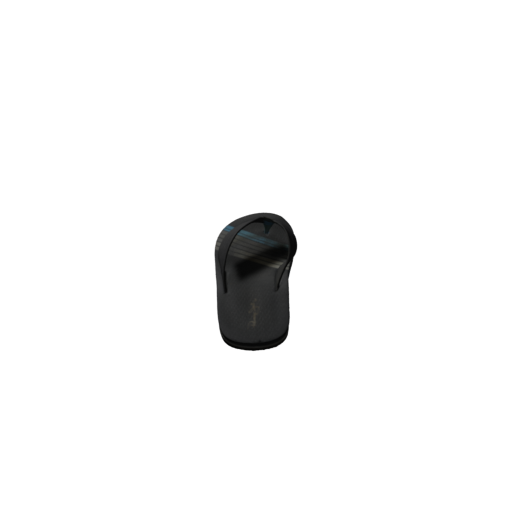

In [ ]:
tester = df.iloc[40, :]
image = Image.open(tester['image_path'])
image

In [ ]:
tester['description']

'** Worn Flip Flop **\n\n*Anti Shock Cushioned Foam with Non Slip Rubber Outsole*\n\n*29.2 x 11.8 x 7.6 cm (85 micrometers per texel @ 4k)*\n\nScanned using advanced technology developed by inciprocal Inc. that enables highly photo-realistic reproduction of real-world products in virtual environments. Our hardware and software technology combines advanced photometry, structured light, photogrammtery and light fields to capture and generate accurate material representations from tens of thousands of images targeting real-time and offline path-traced PBR compatible renderers.\n\nZip file includes low-poly OBJ mesh (in meters) with a set of 4k PBR textures compressed with *lossless* JPEG (no chroma sub-sampling).'

In [ ]:
inputs = processor(text=tester['description'], images=image, return_tensors="pt", padding=True, truncation=True)

outputs = model(**inputs)
outputs.logits_per_image

tensor([[25.6025]], grad_fn=<TBackward0>)

In [ ]:
bat = df[df['model_id']=='0028b77436394fd7963c013e04e69e70'].iloc[0, :]
img_1 = Image.open(bat['image_path'])
img_2 = Image.open(bat['image_path2'])
desc = bat['description']

Score: 24.371904373168945


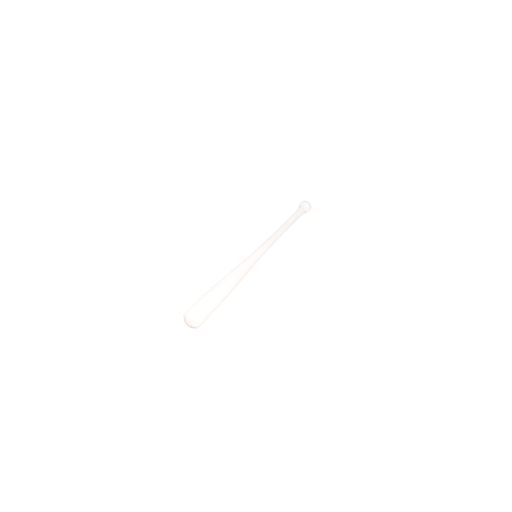

In [ ]:
# Testing how view of the same obj affect score

inputs = processor(text=desc, images=img_1, return_tensors="pt", padding=True, truncation=True)

outputs = model(**inputs)
outputs.logits_per_image
print(f'Score: {float(outputs.logits_per_image[0][0])}')
img_1

Score: 14.962361335754395


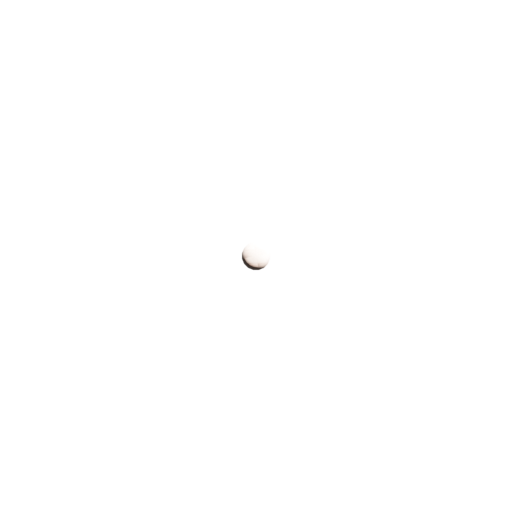

In [ ]:
inputs = processor(text=desc, images=img_2, return_tensors="pt", padding=True, truncation=True)

outputs = model(**inputs)
outputs.logits_per_image
print(f'Score: {float(outputs.logits_per_image[0][0])}')
img_2

As expected, more than one image should be taken into consideration (maybe 3?) to compute the clip score, since there are some views of the same object that are somewhat "unlucky"

In [ ]:
uniq_df = []
for mid in df['model_id'].unique():
  uniq_df.append(df[df['model_id']==mid].sample(3))
uniq_df = pd.concat(uniq_df)

In [ ]:
#######################################################
### DON'T RUN THIS CODE CELL IF YOU VALUE YOUR TIME ###
## I ALREADY DID IT FOR YOU, JUST LOAD THE DATAFRAME ##
#######################################################

dict_scores = {}
dict_keys = ['tags', 'categories', 'description', 'tags&cats', 'desc&tags', 'desc&cats', 'all']
for mid in tqdm(uniq_df['model_id'].unique()):
  tmp = uniq_df[uniq_df['model_id']==mid]
  images_paths = list(tmp['image_path'].unique()) + list(tmp['image_path2'].unique())
  assert len(tmp['description'].unique()==1)
  assert len(tmp['tags'].unique()==1)
  assert len(tmp['categories'].unique()==1)
  images = [Image.open(pth) for pth in images_paths]
  columns = ['tags', 'categories', 'description']
  texts = list(tmp.iloc[0][columns])
  tags = texts[0]
  cats = texts[1]
  for char in ['[', ']', '\'', ',']:
    tags = tags.replace(char, '')
    cats = cats.replace(char, '')

  inputs = processor(text=[tags, cats, texts[2], tags + ' ' + cats, texts[2] + ' ' + tags, texts[2] + ' ' + cats, texts[2] + ' ' + tags + ' ' + cats],
                     images=images, return_tensors="pt", padding=True, truncation=True)
  outputs = model(**inputs)
  out = outputs.logits_per_image.mean(axis=0)
  dict_scores[mid] = {dict_keys[i]: float(score) for i, score in enumerate(out)}

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
def attach_CLIP(v):
  mid = v['model_id']
  scores = dict_scores[mid]
  return pd.Series([scores[k] for k in dict_keys])

col_names = ['CLIP Score tags',
             'CLIP Score categories',
             'CLIP Score description',
             'CLIP Score tags and category',
             'CLIP Score description and tags',
             'CLIP Score description and categories',
             'CLIP Score all']

df[col_names] = df.apply(attach_CLIP, axis=1)

In [ ]:
df.to_csv('/content/drive/MyDrive/ML4CV_poject/CLIP_df.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML4CV_poject/CLIP_df.csv', dtype = {'image_id': str, 'image_id2':str, 'description':str}, na_filter = False)

In [ ]:
uniq_df = []
for mid in df['model_id'].unique():
  uniq_df.append(df[df['model_id']==mid].sample(1))
uniq_df = pd.concat(uniq_df)

In [ ]:
col_names = ['CLIP Score tags',
             'CLIP Score categories',
             'CLIP Score description',
             'CLIP Score tags and category',
             'CLIP Score description and tags',
             'CLIP Score description and categories',
             'CLIP Score all']

uniq_df[col_names].describe()

Soooooo from the describe only seems that only the description could work... Notce that the scores regarding the all column (desc+tags+cat) it's very similar but is a lot more tokens to process for basically the same performances.

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(col_names[:-1]):
  sns.histplot(uniq_df[col], binrange=(11, 38), ax=ax[i//3][i%3])

In [ ]:
tmp = uniq_df[uniq_df['CLIP Score description and tags'] < 18]
sample = tmp.sample(1)
print(sample['description'].iloc[0])
print(sample['tags'].iloc[0])
print(f'Description Score: {sample["CLIP Score description"].iloc[0]}')
print(f'Tags Score: {sample["CLIP Score tags"].iloc[0]}')
print(f'Desc + Tags Score: {sample["CLIP Score description and tags"].iloc[0]}')
Image.open(sample['image_path'].iloc[0])

### Addressing white images [SKIP]

In [ ]:
white_id = uniq_df[uniq_df['description'].str.contains("High-density point-cloud export from Scaniverse")]
white_id

Unnamed: 0                          model_id image_id  \
254040      254040  3b870dc505c54074bf60e058fc3eb6d4      022   

                                               image_path    0         1  \
254040  /content/000-000/3b870dc505c54074bf60e058fc3eb... -0.5  0.866026   

                   2             3         4    5  ...         categories  \
254040 -3.250610e-08  2.100973e-08 -0.866026 -0.5  ...  ['nature-plants']   

                                            description  CLIP Score tags  \
254040  High-density point-cloud export from Scaniverse        19.765863   

        CLIP Score categories  CLIP Score description  \
254040               21.84971               17.685511   

        CLIP Score tags and category CLIP Score description and category  \
254040                     18.591129                           16.874285   

       CLIP Score all CLIP Score description and tags  \
254040      17.178102                        16.94838   

       CLIP Score description and categories  
254040                             16.874285  

[1 rows x 30 columns]

In [ ]:
white_imgs = df[df['model_id'] == '3b870dc505c54074bf60e058fc3eb6d4']
white_imgs

Unnamed: 0                          model_id image_id  \
253968      253968  3b870dc505c54074bf60e058fc3eb6d4      019   
253969      253969  3b870dc505c54074bf60e058fc3eb6d4      019   
253970      253970  3b870dc505c54074bf60e058fc3eb6d4      019   
253971      253971  3b870dc505c54074bf60e058fc3eb6d4      019   
253972      253972  3b870dc505c54074bf60e058fc3eb6d4      019   
...            ...                               ...      ...   
254095      254095  3b870dc505c54074bf60e058fc3eb6d4      012   
254096      254096  3b870dc505c54074bf60e058fc3eb6d4      012   
254097      254097  3b870dc505c54074bf60e058fc3eb6d4      012   
254098      254098  3b870dc505c54074bf60e058fc3eb6d4      012   
254099      254099  3b870dc505c54074bf60e058fc3eb6d4      012   

                                               image_path             0  \
253968  /content/000-000/3b870dc505c54074bf60e058fc3eb...  7.071069e-01   
253969  /content/000-000/3b870dc505c54074bf60e058fc3eb...  5.000000e-01   
253970  /content/000-000/3b870dc505c54074bf60e058fc3eb... -5.000003e-01   
253971  /content/000-000/3b870dc505c54074bf60e058fc3eb... -4.999999e-01   
253972  /content/000-000/3b870dc505c54074bf60e058fc3eb... -4.999999e-01   
...                                                   ...           ...   
254095  /content/000-000/3b870dc505c54074bf60e058fc3eb... -5.000001e-01   
254096  /content/000-000/3b870dc505c54074bf60e058fc3eb... -5.000001e-01   
254097  /content/000-000/3b870dc505c54074bf60e058fc3eb... -1.000000e+00   
254098  /content/000-000/3b870dc505c54074bf60e058fc3eb...  1.000000e+00   
254099  /content/000-000/3b870dc505c54074bf60e058fc3eb... -2.220446e-16   

               1             2             3         4             5  ...  \
253968 -0.500000 -5.000001e-01 -1.224745e+00  0.408248  8.660255e-01  ...   
253969  0.707107 -5.000002e-01 -1.224745e+00 -0.866026  4.082483e-01  ...   
253970  0.866025 -8.033932e-08 -1.148550e-07 -0.866025 -5.000003e-01  ...   
253971 -0.853554  1.464466e-01  3.587194e-01  0.866026 -4.927992e-01  ...   
253972 -0.500000  7.071069e-01  1.732051e+00  0.866026 -2.886750e-01  ...   
...          ...           ...           ...       ...           ...  ...   
254095  0.866026  3.684290e-09  2.452953e-07 -0.707107 -4.082484e-01  ...   
254096 -0.866026 -3.684290e-09 -2.452953e-07  0.707107 -4.082484e-01  ...   
254097  0.000000  0.000000e+00  0.000000e+00  0.000000 -1.343589e-07  ...   
254098  0.000000  0.000000e+00  0.000000e+00  0.000000  7.071070e-01  ...   
254099 -1.000000  0.000000e+00 -2.687177e-07  1.000000  2.983366e-23  ...   

               categories                                      description  \
253968  ['nature-plants']  High-density point-cloud export from Scaniverse   
253969  ['nature-plants']  High-density point-cloud export from Scaniverse   
253970  ['nature-plants']  High-density point-cloud export from Scaniverse   
253971  ['nature-plants']  High-density point-cloud export from Scaniverse   
253972  ['nature-plants']  High-density point-cloud export from Scaniverse   
...                   ...                                              ...   
254095  ['nature-plants']  High-density point-cloud export from Scaniverse   
254096  ['nature-plants']  High-density point-cloud export from Scaniverse   
254097  ['nature-plants']  High-density point-cloud export from Scaniverse   
254098  ['nature-plants']  High-density point-cloud export from Scaniverse   
254099  ['nature-plants']  High-density point-cloud export from Scaniverse   

        CLIP Score tags  CLIP Score categories  CLIP Score description  \
253968        19.765863               21.84971               17.685511   
253969        19.765863               21.84971               17.685511   
253970        19.765863               21.84971               17.685511   
253971        19.765863               21.84971               17.685511   
253972        19.765863               21.84971               17.685511   
...                 

In [ ]:
import torchvision
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
torchvision.io.read_image(white_imgs.sample(1)['image_path2'].iloc[0]).unique() # le immagini bianche contengono solo 0 e 1

tensor([0, 1], dtype=torch.uint8)

In [ ]:
# Non è necessario far girare questa e la prossima cella
# Carico da file salvato nelle prossime celle

def find_white_images(value, white_models, paths):
  model_id = value['model_id']
  if model_id in white_models: return
  path1 = value['image_path']
  if path1 not in paths:
    paths.add(path1)
    un = torchvision.io.read_image(path1).unique()
    if len(un) == 2:
      white_models.add(model_id)
      return
  path2 = value['image_path2']
  if path2 not in paths:
    paths.add(path2)
    un = torchvision.io.read_image(path2).unique()
    if len(un) == 2:
      white_models.add(model_id)
      return
  return

path_set = set({})
model_set = set({})
df.progress_apply(lambda x: find_white_images(x, model_set, path_set), axis=1)

  0%|          | 0/660000 [00:00<?, ?it/s]

0         None
1         None
2         None
3         None
4         None
          ... 
659995    None
659996    None
659997    None
659998    None
659999    None
Length: 660000, dtype: object

In [ ]:
with open('/content/drive/MyDrive/ML4CV_poject/white_models.txt', 'r') as f:
  model_set = set(f.read().split('\n')[:-1])
  f.close()

In [ ]:
def make_collage(model_id):
  rows = df[df['model_id']==model_id]
  img_paths = pd.concat([rows['image_path'], rows['image_path2']]).unique()
  print(f'Description: {rows.iloc[0, :]["description"]}')
  print(f'Tags: {rows.iloc[0, :]["tags"]}')
  imgs = [Image.open(pth) for pth in img_paths]
  new_img_size = (512*3, 512*(len(img_paths)//3))
  collage = Image.new('RGBA', new_img_size)
  for i, img in enumerate(imgs):
    collage.paste(img, (512*(i%3), 512*(i//3)))
  return collage

Description: ** Worn Flip Flop **

*Anti Shock Cushioned Foam with Non Slip Rubber Outsole*

*29.2 x 11.8 x 7.6 cm (85 micrometers per texel @ 4k)*

Scanned using advanced technology developed by inciprocal Inc. that enables highly photo-realistic reproduction of real-world products in virtual environments. Our hardware and software technology combines advanced photometry, structured light, photogrammtery and light fields to capture and generate accurate material representations from tens of thousands of images targeting real-time and offline path-traced PBR compatible renderers.

Zip file includes low-poly OBJ mesh (in meters) with a set of 4k PBR textures compressed with *lossless* JPEG (no chroma sub-sampling).
Tags: ['soft', 'gray', 'shoes', 'foam', 'realistic', 'beach', 'scanned', 'rubber', 'yoga', 'flipflop', 'photometry', 'flipflops', 'pbr-texturing', 'pbr-materials', 'inciprocal']


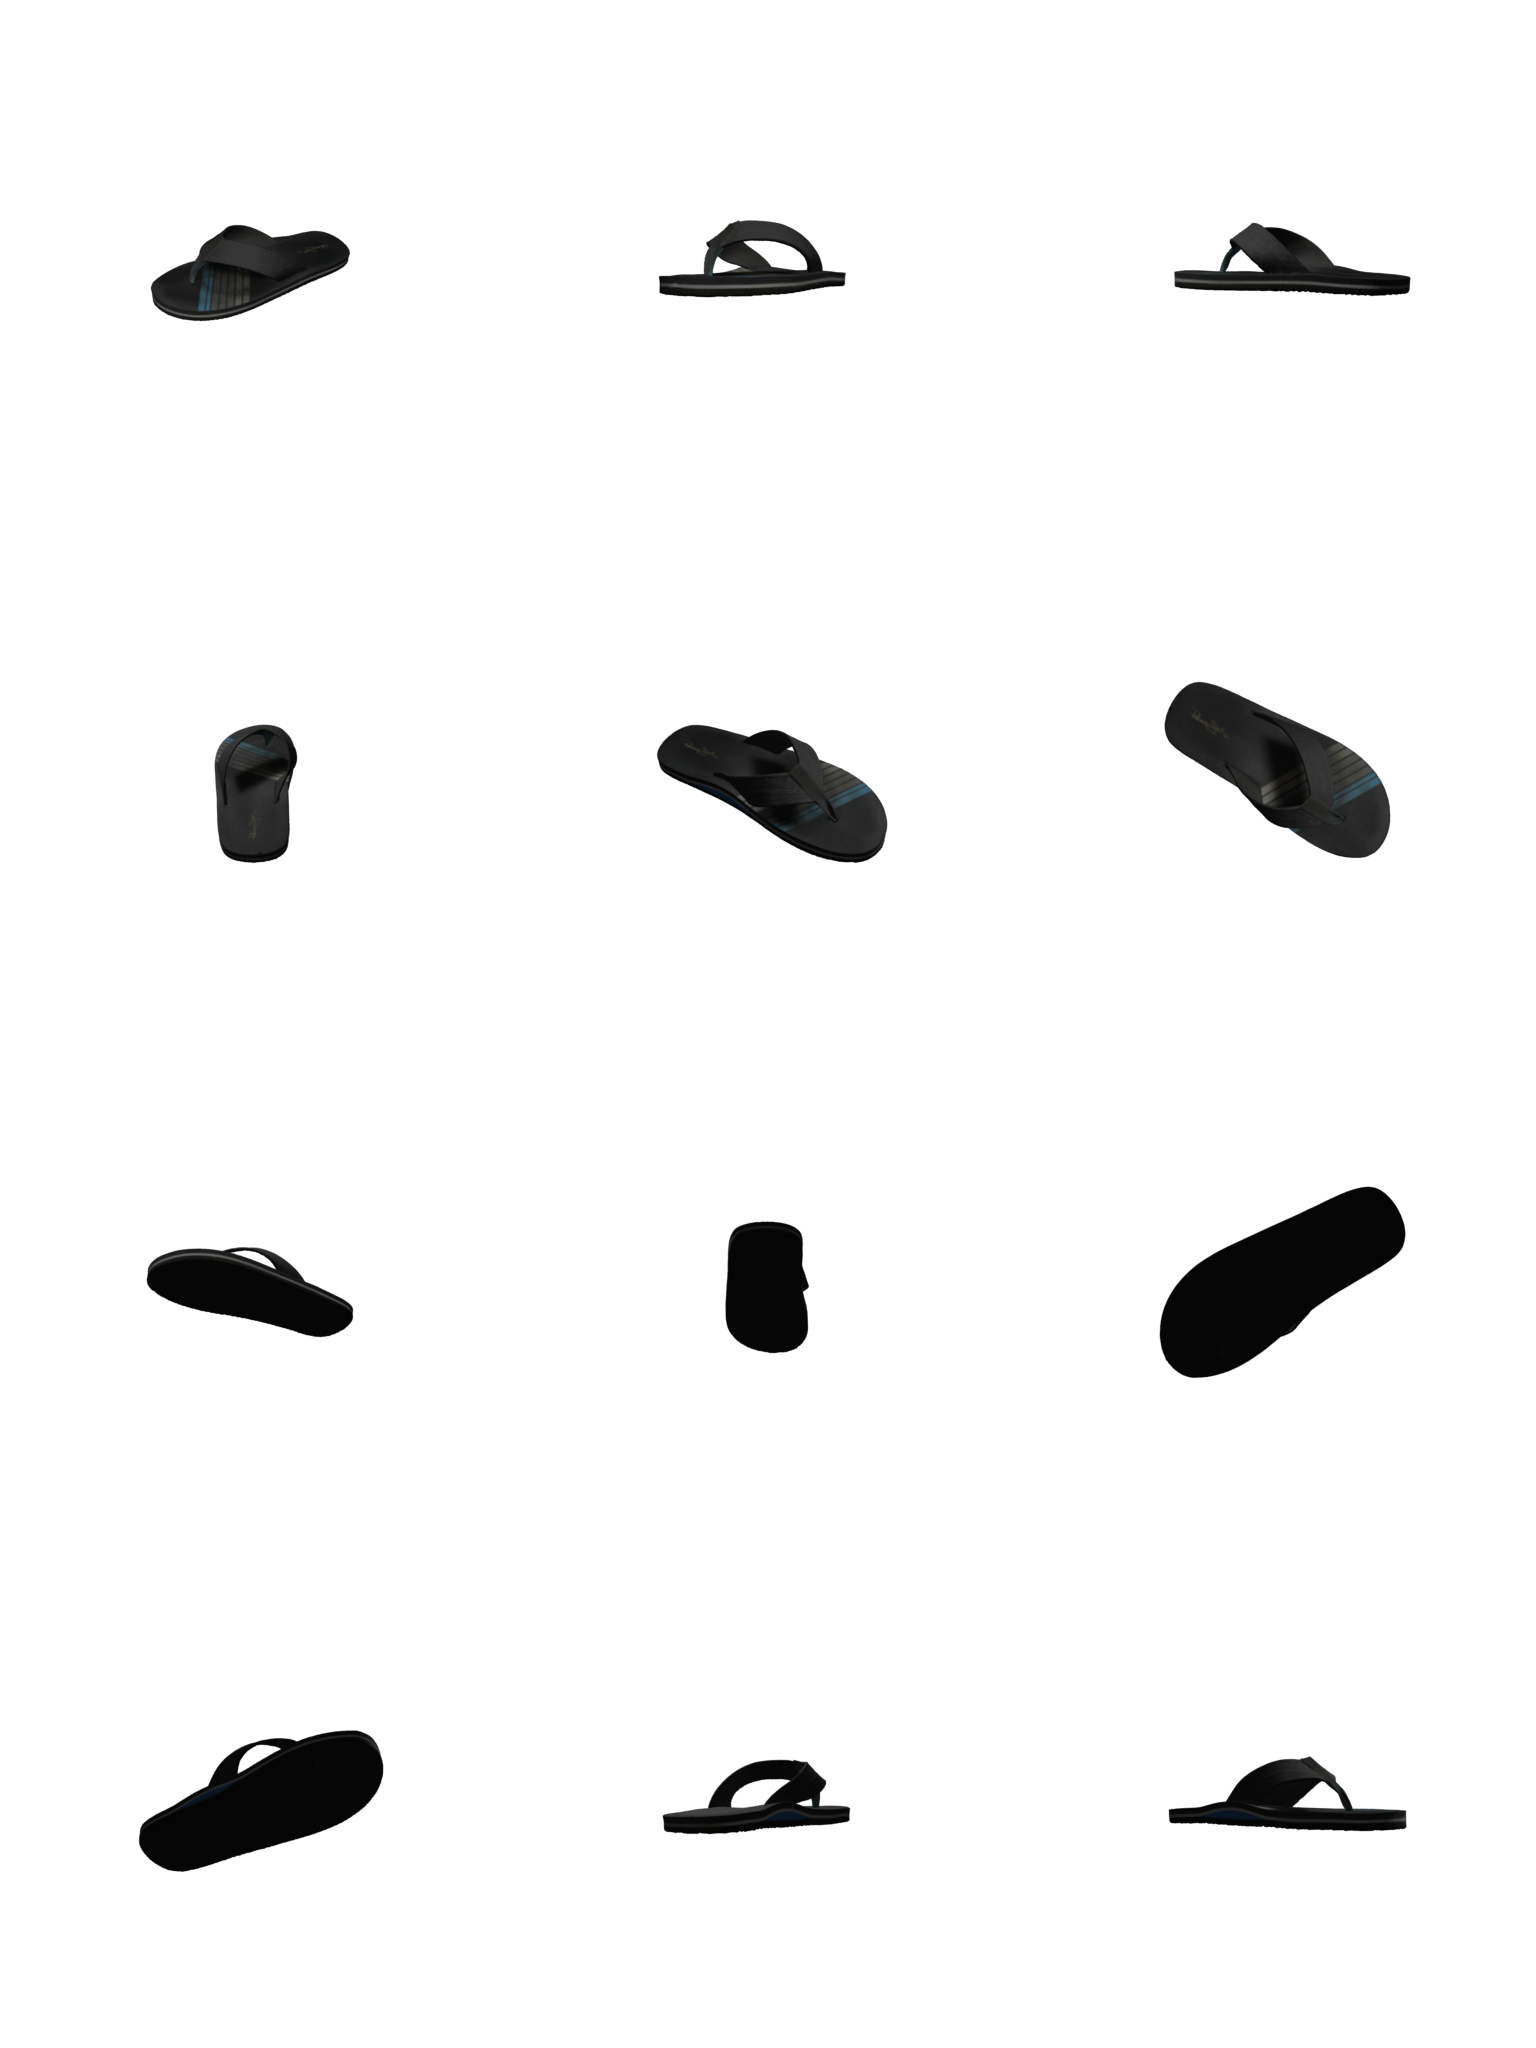

In [ ]:
mid = df.iloc[0, :]['model_id']
make_collage(mid)

Description: Game ui icons
Tags: ['icon', 'buttons', 'ui', 'game', 'mobile']


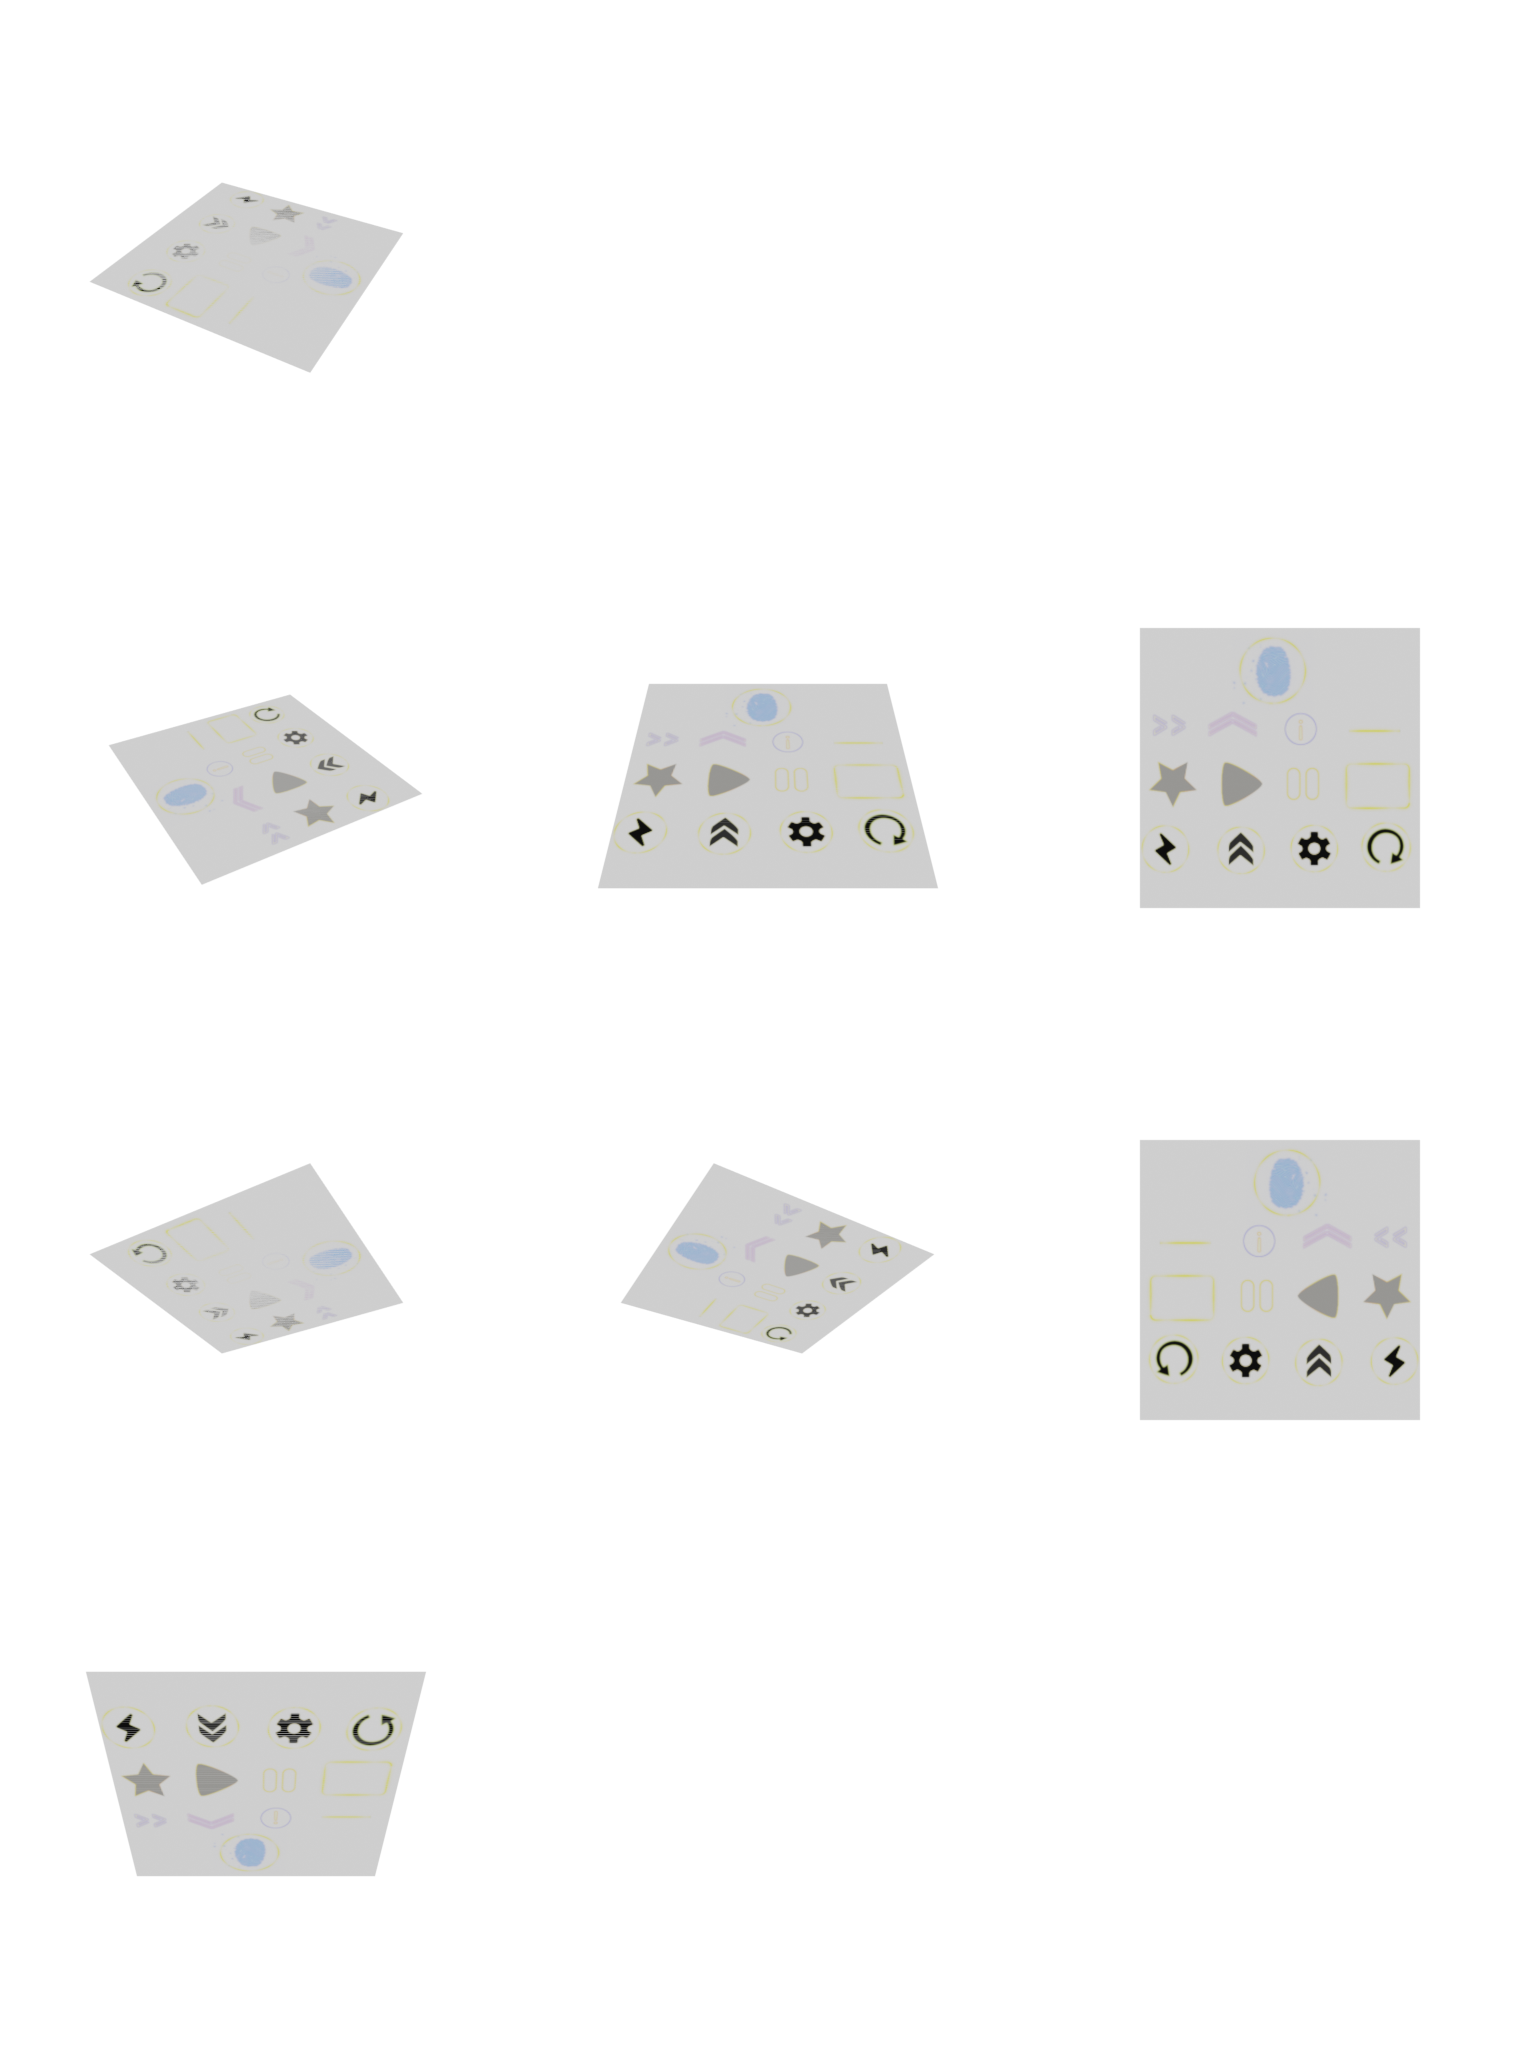

In [ ]:
# 6, 15, 22, 28, 34, 36, 40, 41, 42, 45
# Dei 48 modelli che il mio script aveva segnato come "immagini vuote"
# questi sono gli indici di quelli che hanno sia immagini normali che bianche
# dove le bianche sono spesso dovute alla prospettiva
# Alcuni di questi secondo me vanno comunque scartati, poi mi dirai

model = 42 # @param {type:"integer"}

white_models = sorted(model_set) # To ensure same order, casting to list may result in different order each time...
model = white_models[model]
make_collage(model)

## Load Overfit Dataset

Prima di tutto eliminiamo tutti i modelli sotto una determinata soglia per tag e descrizione. Per ora imposterò come soglia 22

In [5]:
import os
os.path.isfile('./content/drive/MyDrive/ML4CV_poject/CLIP_df.csv')

True

In [6]:
df = pd.read_csv('./content/drive/MyDrive/ML4CV_poject/CLIP_df.csv', dtype = {'image_id': str, 'image_id2':str, 'description':str}, na_filter = False)

In [7]:
#ONLY FOR LOCAL!
df['image_path'] = "."+df["image_path"]
df['image_path2'] = "."+df["image_path2"]

In [8]:
df.head()

Unnamed: 0                          model_id image_id  \
0           0  000074a334c541878360457c672b6c2e      019   
1           1  000074a334c541878360457c672b6c2e      019   
2           2  000074a334c541878360457c672b6c2e      019   
3           3  000074a334c541878360457c672b6c2e      019   
4           4  000074a334c541878360457c672b6c2e      019   

                                          image_path         0         1  \
0  ./content/000-000/000074a334c541878360457c672b...  0.707107 -0.500000   
1  ./content/000-000/000074a334c541878360457c672b...  0.500000  0.707107   
2  ./content/000-000/000074a334c541878360457c672b... -0.500000  0.866025   
3  ./content/000-000/000074a334c541878360457c672b... -0.500000 -0.853553   
4  ./content/000-000/000074a334c541878360457c672b... -0.500000 -0.500000   

              2             3         4         5  ...  \
0 -5.000001e-01 -1.224745e+00  0.408248  0.866025  ...   
1 -5.000003e-01 -1.224746e+00 -0.866026  0.408248  ...   
2 -5.462510e-08 -3.363853e-07 -0.866025 -0.500000  ...   
3  1.464465e-01  3.587193e-01  0.866025 -0.492799  ...   
4  7.071068e-01  1.732051e+00  0.866025 -0.288675  ...   

                            categories  \
0  ['fashion-style', 'sports-fitness']   
1  ['fashion-style', 'sports-fitness']   
2  ['fashion-style', 'sports-fitness']   
3  ['fashion-style', 'sports-fitness']   
4  ['fashion-style', 'sports-fitness']   

                                         description  CLIP Score tags  \
0  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...        26.482109   
1  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...        26.482109   
2  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...        26.482109   
3  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...        26.482109   
4  ** Worn Flip Flop **\n\n*Anti Shock Cushioned ...        26.482109   

   CLIP Score categories  CLIP Score description  \
0               19.49855               26.639318   
1               19.49855               26.639318   
2               19.49855               26.639318   
3               19.49855               26.639318   
4               19.49855               26.639318   

   CLIP Score tags and category CLIP Score description and category  \
0                     25.531084                           26.639318   
1                     25.531084                           26.639318   
2                     25.531084                           26.639318   
3                     25.531084                           26.639318   
4                     25.531084                           26.639318   

  CLIP Score all CLIP Score description and tags  \
0      26.639313                       26.639318   
1      26.639313                       26.639318   
2      26.639313                       26.639318   
3      26.639313                       26.639318   
4      26.639313                       26.639318   

  CLIP Score description and categories  
0                             26.639318  
1                             26.639318  
2                             26.639318  
3                             26.639318  
4                             26.639318  

[5 rows x 30 columns]

In [42]:
#projection matrix min max and std
df[[str(i) for i in range(12)]].std(axis=0)

0     0.633109
1     0.633653
2     0.435194
3     1.002523
4     0.633653
5     0.529984
6     0.544680
7     1.126587
8     0.435194
9     0.544680
10    0.516078
11    1.114133
dtype: float64

In [9]:
def delete_thr(df, thr, column='CLIP Score description and tags'):
  rem_df = df[df[column] <= thr]
  print(f'Removed {len(rem_df["model_id"].unique())} models. ({rem_df.shape[0]} rows)')
  return df[df[column] > thr].reset_index(drop=True)

In [10]:
clean_df = delete_thr(df, 24)

Removed 2779 models. (366828 rows)


Ora cerco di trovare dei modelli che mi piacciono da eliminare dal dataframe e da tenere come test **che non è presente nel train**.

In [11]:
good_models = clean_df[clean_df['CLIP Score description and tags'] > 35]['model_id'].unique()

In [12]:
good_models

array(['0098586123fc435f86c7f5cb3d3b8a79',
       '0162dea1b1044cd281c57af5e5fc2046',
       '017c2dbbc5034eba8dbf46e44dbddb62',
       '0241e66e7f93462ea3cddfb1f326d753',
       '12f9ff84a68747dcbb7289447b741127',
       '5c3426b63be04d5b84c73d6ff77aeea8',
       '775165a5e097493da55d81e1ce0d990a',
       'ac8f59369cbe457bb1331e88f13d61af',
       'b3bfd8ec7a1849f0bade5298dc207340',
       'b59a7634e4ed43b0a5f7ae309253244e'], dtype=object)

In [13]:
def make_collage(model_id):
  rows = df[df['model_id']==model_id]
  img_paths = pd.concat([rows['image_path'], rows['image_path2']]).unique()
  print(f'Description: {rows.iloc[0, :]["description"]}')
  print(f'Tags: {rows.iloc[0, :]["tags"]}')
  imgs = [Image.open(pth) for pth in img_paths]
  new_img_size = (512*3, 512*(len(img_paths)//3))
  collage = Image.new('RGBA', new_img_size)
  for i, img in enumerate(imgs):
    collage.paste(img, (512*(i%3), 512*(i//3)))
  return collage

Description: Small low-poly extinguisher.
Tags: ['extinguisher', 'equipment', 'protection', 'fireman', '3d', 'blender', 'lowpoly']


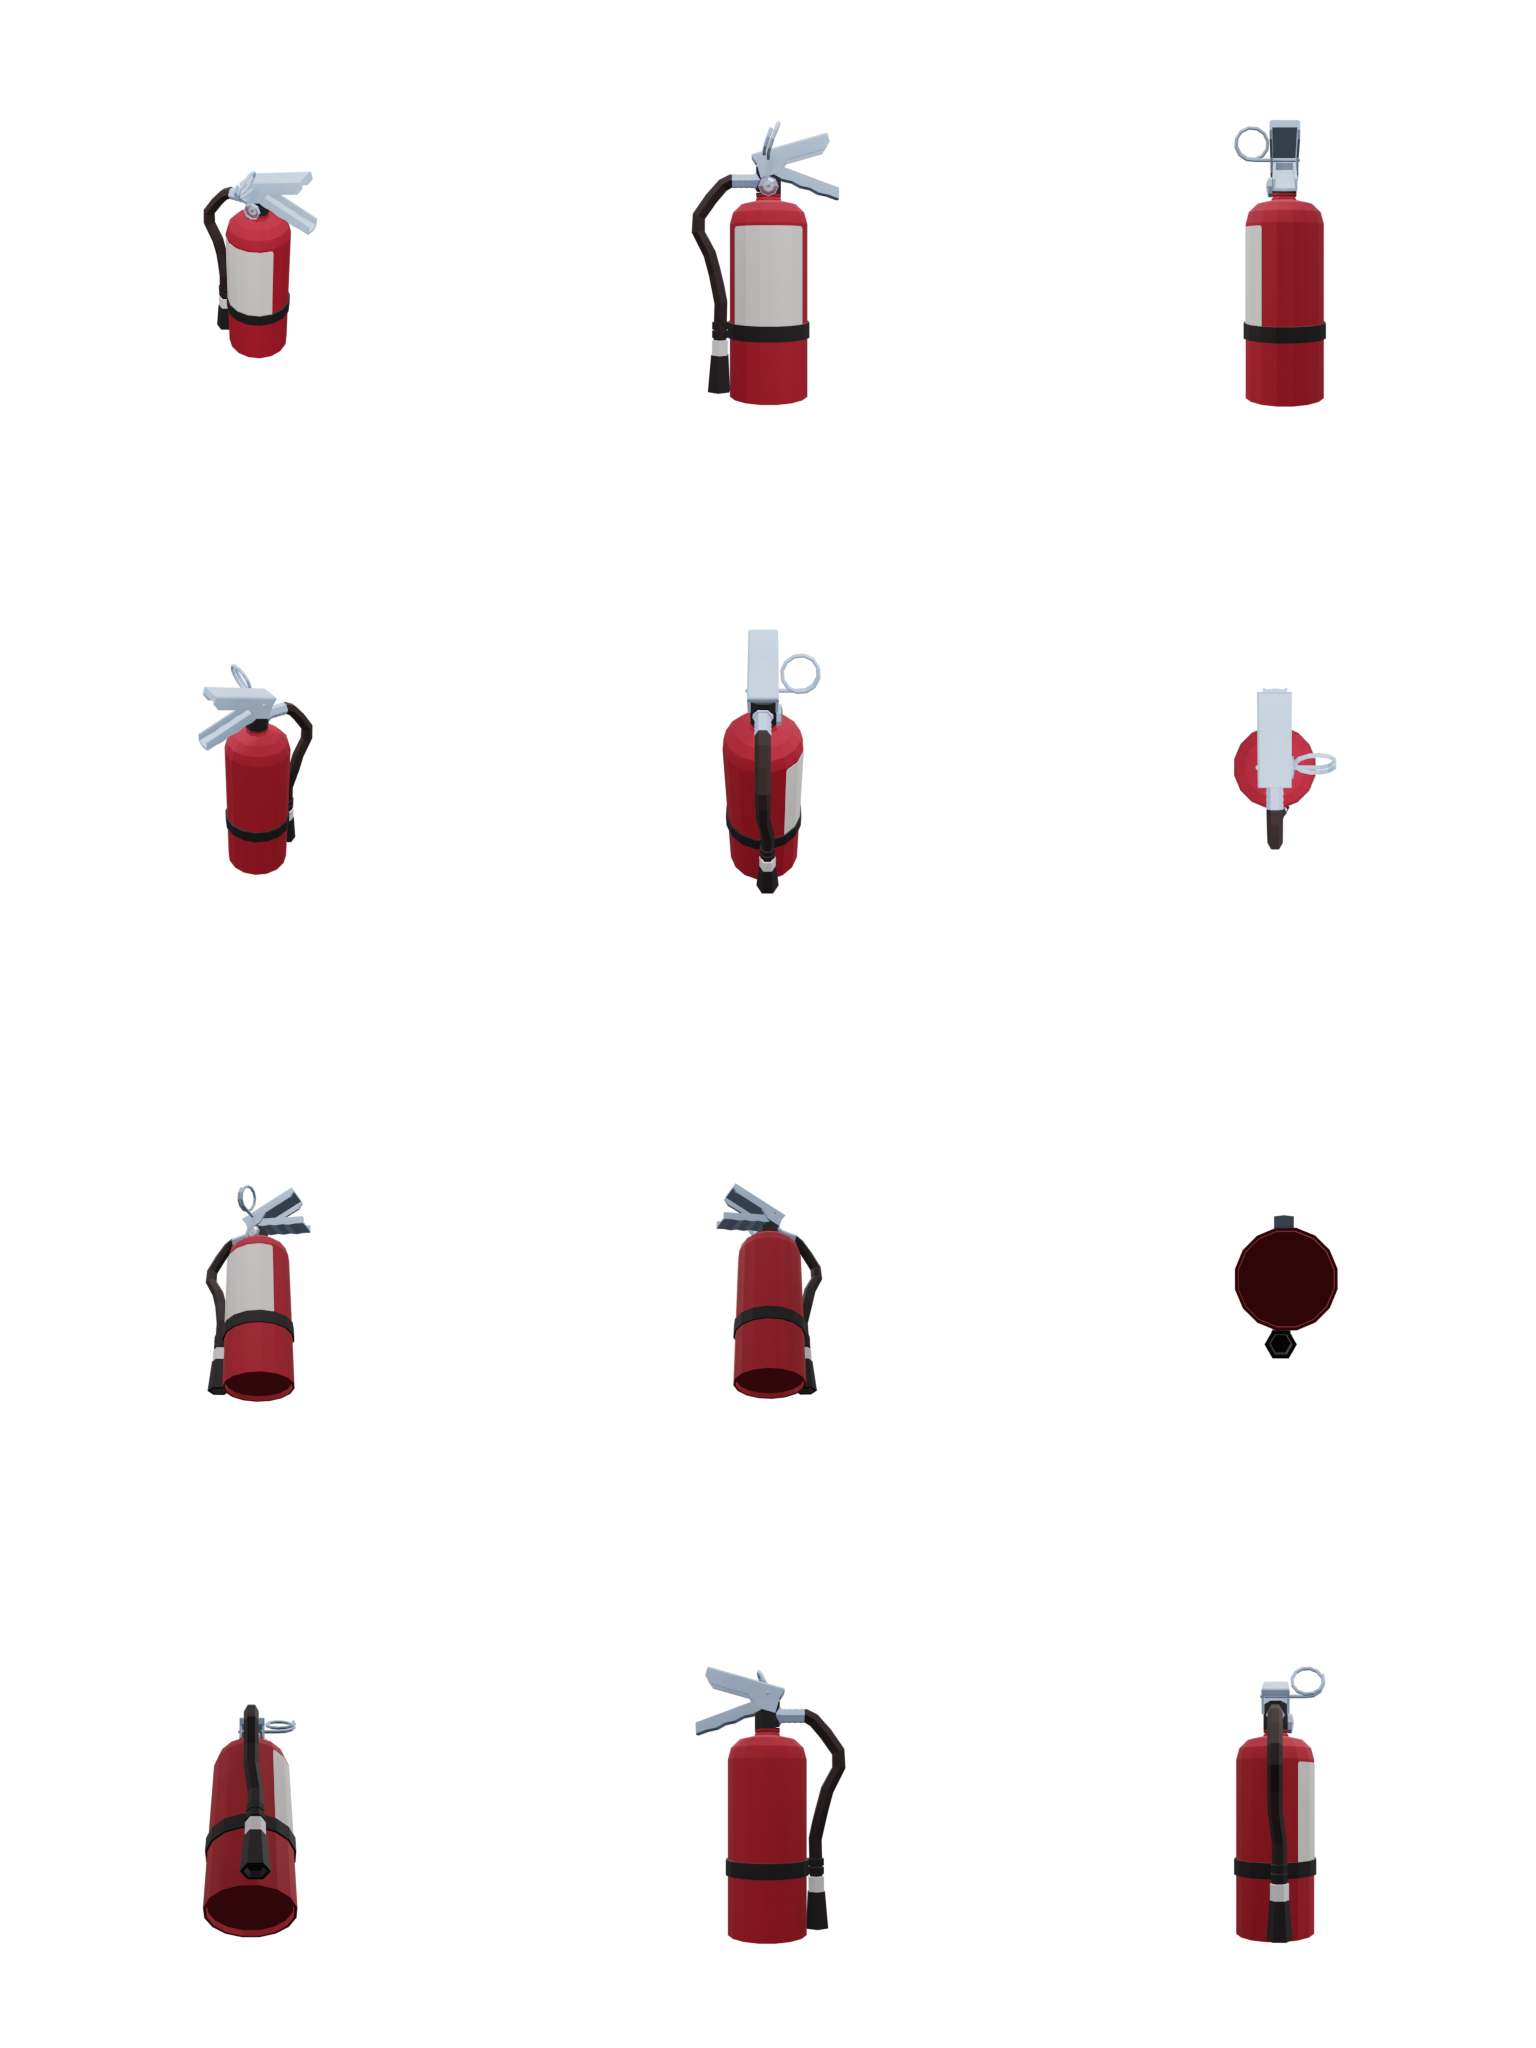

In [14]:
# 0098586123fc435f86c7f5cb3d3b8a79
# 017c2dbbc5034eba8dbf46e44dbddb62
# 5c3426b63be04d5b84c73d6ff77aeea8
# b59a7634e4ed43b0a5f7ae309253244e

model = 9 # @param {type:"integer"}

model = good_models[model]
make_collage(model)

In [16]:
# Ho selezionato questi 4 perché mi sembravano avere il giusto equilibrio tr complessità e semplicità, ma se ne può parlare

test_models = ['0098586123fc435f86c7f5cb3d3b8a79',
               '017c2dbbc5034eba8dbf46e44dbddb62',
               '5c3426b63be04d5b84c73d6ff77aeea8',
               'b59a7634e4ed43b0a5f7ae309253244e']

In [17]:
clean_df = clean_df[~(clean_df['model_id'].str.contains('|'.join(test_models)))].reset_index(drop=True)

In [18]:
def create_train_test(to_split, split=0.2):
  models = to_split['model_id'].unique()
  train = []
  test = []
  for model in models:
    tmp = to_split[to_split['model_id']==model]
    tmp_train, tmp_test = train_test_split(tmp, test_size=split)
    train.append(tmp_train)
    test.append(tmp_test)
  return pd.concat(train).reset_index(drop=True), pd.concat(test).reset_index(drop=True)

In [21]:
train_df, test_df = create_train_test(clean_df)

In [22]:
# crea un dataframe in cui ogni riga è un model id
# e per ogni model id conta quanti esemplari ci sono in train e quanti in test

def compare_train_test(train, test):
  df_dict = {}
  for model in train['model_id'].unique():
    in_train = train[train['model_id']==model].shape[0]
    in_test = test[test['model_id']==model].shape[0]
    df_dict[model] = {'# in train': in_train, '# in test': in_test}
  return pd.DataFrame.from_dict(df_dict, orient='index')

In [23]:
compare_df = compare_train_test(train_df, test_df)

In [24]:
compare_df.describe()

# in train  # in test
count      2217.0     2217.0
mean        105.0       27.0
std           0.0        0.0
min         105.0       27.0
25%         105.0       27.0
50%         105.0       27.0
75%         105.0       27.0
max         105.0       27.0

mi aspettavo questo risultato, ma sempre meglio essere sicuri al 100%

## Models

In [25]:
import sys
sys.path.append('./content/drive/MyDrive/ML4CV_poject/utils')

In [26]:
sys.path

['C:\\Python311\\python311.zip',
 'C:\\Python311\\DLLs',
 'C:\\Python311\\Lib',
 'C:\\Python311',
 'c:\\Users\\VarLab\\Desktop\\JacopoMeglioraldi\\Camtrolnet\\camtrolnet',
 '',
 'c:\\Users\\VarLab\\Desktop\\JacopoMeglioraldi\\Camtrolnet\\camtrolnet\\Lib\\site-packages',
 'c:\\Users\\VarLab\\Desktop\\JacopoMeglioraldi\\Camtrolnet\\camtrolnet\\Lib\\site-packages\\win32',
 'c:\\Users\\VarLab\\Desktop\\JacopoMeglioraldi\\Camtrolnet\\camtrolnet\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\VarLab\\Desktop\\JacopoMeglioraldi\\Camtrolnet\\camtrolnet\\Lib\\site-packages\\Pythonwin',
 './content/drive/MyDrive/ML4CV_poject/utils']

In [27]:
import camtrolnet
from importlib import reload
reload(camtrolnet)
from camtrolnet import CamtrolNetModel

In [28]:
#models from controlnet_train.py official

import diffusers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from diffusers.utils import load_image
from transformers import CLIPTextModel
import torch

#channels
channels = 3
latent_channels = 4 #default

# base model
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
revision = None #'non-ema'
variant = None

# import correct text encoder class
text_encoder_cls = CLIPTextModel

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision, variant=variant
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant, in_channels=channels,
    low_cpu_mem_usage=False, ignore_mismatched_sizes=True
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant, in_channels=latent_channels,
)

#controlnet = ControlNetModel.from_unet(unet, conditioning_channels=3)
#controlnet = CamtrolNetModel.from_unet(unet, conditioning_channels=3)
controlnet = ControlNetModel.from_unet(unet, conditioning_channels=3+12)

optimizer_class = bnb.optim.AdamW8bit

params_to_optimize = controlnet.parameters()
optimizer = optimizer_class(
    params_to_optimize

    # For now I commented this params out since I wasn't really sure on what to put in there...
    # Let's leave the defaults for the time being, we can customize them later...

    # lr=learning_rate,
    # betas=(adam_beta1, adam_beta2),
    # weight_decay=adam_weight_decay,
    # eps=adam_epsilon,
)
#------

## Saving Controlnet and Encoder Functions

In [29]:
def save_controlnet(controlnet, name="controlnet_v1", to_drive = False):
  if to_drive:
    model_drive_path = os.path.join(os.path.split(os.path.split(drive_path)[0])[0], "models")
    controlnet.save_pretrained(os.path.join(model_drive_path, str(name) ))
  else:
    controlnet.save_pretrained("./content/model/"+str(name))

def load_controlnet(controlnet, name="controlnet_v1", from_drive = False):
  if from_drive:
    model_drive_path = os.path.join(os.path.split(os.path.split(drive_path)[0])[0], "models")
    controlnet.from_pretrained(os.path.join(model_drive_path, str(name) ))
  else:
    controlnet.from_pretrained("./content/model/"+str(name))
  controlnet.train()

In [30]:
def save_camera_encoder(encoder, name="encoder_v1", to_drive = False):
  if to_drive:
    model_drive_path = os.path.join(os.path.split(os.path.split(drive_path)[0])[0], "models")
    torch.save(encoder.state_dict(), os.path.join(model_drive_path, str(name)+".pth" ))
  else:
    torch.save(encoder.state_dict(), "./content/model/"+str(name)+".pth")

def load_camera_encoder(encoder, name="encoder_v1", from_drive = False):
  if from_drive:
    model_drive_path = os.path.join(os.path.split(os.path.split(drive_path)[0])[0], "models")
    encoder.load_state_dict(torch.load(os.path.join(model_drive_path, str(name)+".pth" )))
  else:
    encoder.load_state_dict(torch.load("./content/model/"+str(name)+".pth"))

In [47]:
#save_controlnet(controlnet, to_drive = True)
#load_controlnet(controlnet, from_drive = True)
#save_camera_encoder(camera_encoder, to_drive = True)
#load_camera_encoder(camera_encoder, from_drive=True)

## Camera Position encoder (Convolution)

I barely know if this is correct, but it's an honest try I guess

In [31]:
from torch.nn import Flatten, Linear, Conv2d, ReLU, ConvTranspose2d, ModuleList, SiLU

In [33]:
class TransposeCameraEncoder(torch.nn.Module):

  def __init__(self, target_res=512, out_channels=3, max_hidden_channels=64):
    super(TransposeCameraEncoder, self).__init__()
    self.flat = Flatten()
    self.lin1 = Linear(12, 16)
    self.target_res = target_res
    self.out_channels = out_channels
    necessary_layers = 0.5*np.log2(target_res) # Basically log in base 4
    self.transposed_convs = ModuleList()
    if not necessary_layers.is_integer():
      # Se il log in base 4 non è intero significa che il risultato finale è una potenza di 2 ma non di 4
      # Quindi aggiungiamo una Tconv che raddoppia le dimensioni
      # In questo modo siamo sicuri che partendo da 8x8 invece che da 4x4 ci rientriamo
      self.transposed_convs.append(ConvTranspose2d(1, 1, 2, stride=2))
    pow4 = 1-int(necessary_layers.is_integer()) # Don't question my methods
    for i in range(int(necessary_layers)-1):
      in_ch = 4**(i+pow4) if 4**(i+pow4) <= max_hidden_channels else max_hidden_channels
      # Not a typo! in_ch = out_ch by design
      self.transposed_convs.append(ConvTranspose2d(in_ch, in_ch, 4, stride=4))

    self.convs = ModuleList()
    for i, _ in enumerate(self.transposed_convs):
      in_ch = 4**(i) if 4**(i) <= max_hidden_channels else max_hidden_channels
      out_ch = 4**(i+1) if 4**(i+1) <= max_hidden_channels else max_hidden_channels
      self.convs.append(Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
    self.out = Conv2d(4**(len(self.convs)) if 4**(len(self.convs)) <= max_hidden_channels else max_hidden_channels, self.out_channels, 1)

  # change relu to silu

  def forward(self, x):
    x = self.flat(x)
    x = self.lin1(x)
    x = SiLU()(x)
    bsz = x.shape[0]
    x = x.view((bsz, 1, 4, 4))
    for i in range(len(self.transposed_convs)):
      x = self.transposed_convs[i](x)
      x = SiLU()(x)
      x = self.convs[i](x)
      x = SiLU()(x)
    x = self.out(x)
    return x

In [34]:
camera_encoder = TransposeCameraEncoder(target_res = 64, max_hidden_channels=320, out_channels = 320)

In [ ]:
!pip install torchsummary

In [35]:
from torchsummary import summary
summary(camera_encoder, (1, 1, 3, 4), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 12]               0
            Linear-2                   [-1, 16]             208
   ConvTranspose2d-3            [-1, 1, 16, 16]              17
            Conv2d-4            [-1, 4, 16, 16]              40
   ConvTranspose2d-5            [-1, 4, 64, 64]             260
            Conv2d-6           [-1, 16, 64, 64]             592
            Conv2d-7          [-1, 320, 64, 64]           5,440
Total params: 6,557
Trainable params: 6,557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 10.63
Params size (MB): 0.03
Estimated Total Size (MB): 10.66
----------------------------------------------------------------


In [36]:
tester = torch.rand((2, 1, 3, 4))
tester

tensor([[[[0.9639, 0.1015, 0.9388, 0.3991],
          [0.4027, 0.1598, 0.2561, 0.4295],
          [0.3935, 0.6913, 0.4904, 0.1109]]],


        [[[0.3966, 0.4466, 0.1767, 0.3122],
          [0.8509, 0.6788, 0.0964, 0.9762],
          [0.6514, 0.6161, 0.6266, 0.4170]]]])

In [37]:
camera_encoder(tester).shape

torch.Size([2, 320, 64, 64])

## Camera Position Encoder (Concat)
Remember to edit the training loop

In [43]:
def create_camera_encodings(shape, camera):
  #shape has to be dimension 2
  camera = camera.flatten(start_dim = -2, end_dim = -1).reshape(camera.shape[0],-1, 1, 1)
  if isinstance(camera, np.ndarray):
    camera = np.tile(camera,(1,1,shape[0],shape[1]))
  elif torch.is_tensor(test_camera):
    camera = camera.repeat((1,1,shape[0],shape[1]))
  return camera


In [44]:
test_camera = np.array([[[1,2,3,4],[5,6,7,8],[9,10,11,12]],[[1,2,3,4],[5,6,7,8],[9,10,11,12]]])
test_camera = torch.Tensor(test_camera)
camera_encodings = create_camera_encodings((2,3),test_camera)
print(camera_encodings, camera_encodings.shape)

tensor([[[[ 1.,  1.,  1.],
          [ 1.,  1.,  1.]],

         [[ 2.,  2.,  2.],
          [ 2.,  2.,  2.]],

         [[ 3.,  3.,  3.],
          [ 3.,  3.,  3.]],

         [[ 4.,  4.,  4.],
          [ 4.,  4.,  4.]],

         [[ 5.,  5.,  5.],
          [ 5.,  5.,  5.]],

         [[ 6.,  6.,  6.],
          [ 6.,  6.,  6.]],

         [[ 7.,  7.,  7.],
          [ 7.,  7.,  7.]],

         [[ 8.,  8.,  8.],
          [ 8.,  8.,  8.]],

         [[ 9.,  9.,  9.],
          [ 9.,  9.,  9.]],

         [[10., 10., 10.],
          [10., 10., 10.]],

         [[11., 11., 11.],
          [11., 11., 11.]],

         [[12., 12., 12.],
          [12., 12., 12.]]],


        [[[ 1.,  1.,  1.],
          [ 1.,  1.,  1.]],

         [[ 2.,  2.,  2.],
          [ 2.,  2.,  2.]],

         [[ 3.,  3.,  3.],
          [ 3.,  3.,  3.]],

         [[ 4.,  4.,  4.],
          [ 4.,  4.,  4.]],

         [[ 5.,  5.,  5.],
          [ 5.,  5.,  5.]],

         [[ 6.,  6.,  6.],
          [ 6.,  6.

### Test every step of the model [SKIP]

In [ ]:
# t = train_dataset[0][0].to(dtype=torch.float32)[:3, :, :]
# t.shape

t = torch.rand((1, 3, 512, 512)).to(device="cuda")

In [ ]:
_ = vae.to(device = 'cuda')

In [ ]:
with torch.no_grad():
  latents = vae.encode(t).latent_dist.sample()

In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

In [71]:
#test with real image
image1, label, camera, image2 = train_dataset.__getitem__(50)
image1 = torch.reshape(image1, [1, 3, 512, 512]).to(device='cuda')
with torch.no_grad():
  latents = vae.encode(image1).latent_dist.sample()
latents = latents * vae.config.scaling_factor

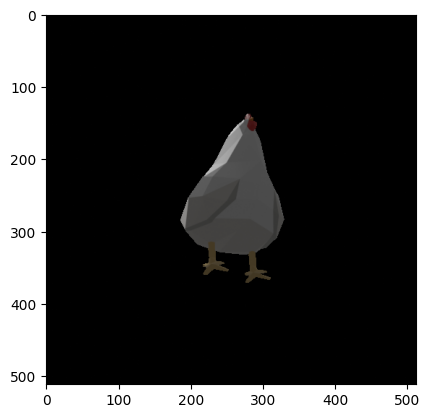

In [81]:
plt.imshow(image2.squeeze().permute(1,2,0))

In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

In [ ]:
camera

tensor([[-5.0000e-01, -8.6603e-01, -1.3843e-10,  7.5129e-09],
        [ 1.4645e-01, -8.4551e-02,  9.8560e-01,  1.9712e+00],
        [-8.5355e-01,  4.9280e-01,  1.6910e-01, -2.1113e+00]])

In [ ]:
with torch.no_grad():
  camera_latents = camera_encoder(camera.view((1, 1, 3, 4)))
camera_latents.shape

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
complete_latents = latents + camera_latents

RuntimeError: The size of tensor a (4) must match the size of tensor b (320) at non-singleton dimension 1

In [ ]:
camera_encodings = create_camera_encodings(tuple(image2.shape[1:]), camera[None,:,:])

In [ ]:
print(camera_encodings.shape)

torch.Size([1, 12, 512, 512])


In [ ]:
image2 = image2[None,:,:,:]

In [ ]:
cond_image_concat = torch.cat([image2,camera_encodings], axis = 1)
print(cond_image_concat.shape)

torch.Size([1, 15, 512, 512])


In [ ]:
text_encoder = text_encoder_cls.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder", revision=revision, variant=variant
    )

In [ ]:
# purtroppo l'immagine 50 non ha label, quindi mi sono spostato alla 51 :(

timage, tlabel, tcamera, timage2 = train_dataset[51]
tlabel

NameError: name 'sef' is not defined

In [ ]:
text_encoder.to(device='cuda')

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [ ]:
tlabel=tlabel.to(device='cuda')


In [ ]:
a = torch.reshape(tlabel, (1, 77))

In [ ]:
with torch.no_grad():
  encoded_text = text_encoder(a, return_dict=False)[0]
encoded_text

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0413, -0.9504,  1.3384,  ..., -0.0930,  0.5449, -0.2270],
         [ 1.5874, -1.5263,  0.8198,  ..., -1.3911,  2.7066,  0.7243],
         ...,
         [ 0.5345, -0.0817,  0.8731,  ..., -0.1850,  0.7385, -0.6711],
         [ 0.4710, -0.0173,  0.7238,  ...,  0.2358, -0.3084,  0.3827],
         [ 0.1874,  0.4461,  0.8068,  ..., -1.6174, -0.5072,  0.2177]]],
       device='cuda:0')

In [ ]:
latents = latents.to(device='cuda')

In [ ]:
# La prima assume batch size=1 per semplicità, chiaramente cambieremo

timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (1,), device=latents.device)
timesteps = timesteps.long()

In [ ]:
timesteps

tensor([186], device='cuda:0')

In [ ]:
noise = torch.randn_like(latents)
noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

In [ ]:
controlnet.to(device='cuda')

ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(15, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ke

In [ ]:
camera_latents = camera_latents.to(device="cuda")

NameError: name 'camera_latents' is not defined

In [ ]:
with torch.no_grad():
  down_block_res_samples, mid_block_res_sample = controlnet(
                                                            noisy_latents,
                                                            timesteps,
                                                            encoder_hidden_states=encoded_text,
                                                            controlnet_cond=cond_img,
                                                            camera_cond = camera_latents,
                                                            return_dict=False,
                                                        )

NameError: name 'cond_img' is not defined

In [ ]:
# Qualcosa mi dice che non va bene...

mid_block_res_sample

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [ ]:
cond_image_concat = torch.reshape(cond_image_concat, (1, 15, 512, 512))
cond_image_concat = cond_image_concat.to(device='cuda')

In [ ]:
with torch.no_grad():
  down_block_res_samples, mid_block_res_sample = controlnet(
                                                            noisy_latents,
                                                            timesteps,
                                                            encoder_hidden_states=encoded_text,
                                                            controlnet_cond=cond_image_concat,
                                                            return_dict=False,
                                                        )

In [ ]:
unet.to(device='cuda')

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
pred = unet(noisy_latents,
            timesteps,
            encoder_hidden_states=encoded_text,
            down_block_additional_residuals=[sample.to(dtype=torch.float16) for sample in down_block_res_samples],
            mid_block_additional_residual=mid_block_res_sample.to(dtype=torch.float16),
            return_dict=False)

In [ ]:
pred

(tensor([[[[-1.5697,  1.0105, -0.6850,  ...,  0.0973, -0.6003, -0.8180],
           [ 1.5725,  1.3448, -0.6828,  ...,  0.9817,  0.8873, -0.0069],
           [ 0.7022,  0.0052,  0.8817,  ...,  0.9255,  2.0338, -0.8147],
           ...,
           [ 2.4885,  0.2838, -0.4377,  ..., -0.7333, -1.4267,  0.0948],
           [-1.2359, -0.6370, -1.2650,  ..., -0.3224, -0.4971,  2.0284],
           [ 0.7682,  0.6855,  0.6403,  ...,  1.0457, -2.7075,  0.3551]],
 
          [[-1.1985, -2.1310, -0.3690,  ..., -0.4755, -2.5700, -1.0807],
           [-1.0293, -0.8352, -0.3982,  ...,  1.1325, -0.2421,  0.0810],
           [-0.2366,  0.5918,  0.7014,  ..., -0.3524, -0.1374,  0.6793],
           ...,
           [ 1.3157,  0.6395,  0.4494,  ..., -0.8845,  0.3640,  1.2824],
           [-0.7988,  0.2243, -1.4242,  ..., -0.4402,  1.2195, -2.2852],
           [-1.0847, -0.1596,  2.2471,  ...,  0.1397,  0.5027,  0.3837]],
 
          [[ 0.5081, -1.2541, -0.0629,  ...,  0.7287, -0.4929, -0.1096],
           [-

In [ ]:
#free memory of testing
if "t" in globals(): del t
if "image1" in globals(): del image1
if "camera_latents" in globals(): del camera_latents
if "tlabel" in globals(): del tlabel
if "latents" in globals(): del latents
if "cond_img" in globals(): del cond_img
if "cond_image_concat" in globals(): del cond_image_concat

## Training loop

In [45]:
def collate_fn(ex):
  batch = {}
  dict_keys = ['input_imgs', 'texts', 'camera', 'rotated_imgs']
  for i, k in enumerate(dict_keys):
    batch[k] = torch.stack(list(torch.Tensor(ex[j][i]) for j in range(len(ex))))

  return batch

In [46]:
overfit_train = df[df['model_id'].str.contains('|'.join([test_models[0], test_models[1]]))]

In [47]:
train_dataset = CustomImageDataset(overfit_train, transform = image_transforms, target_transform = conditioning_image_transforms, channels=channels)

In [48]:
BATCH_SIZE = 4

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [49]:
print(f"Blocks on gpu? VAE {vae.device}, CLIP {text_encoder.device}, CONTROLNET {controlnet.device}, UNET {unet.device}, CameraEnc {next(camera_encoder.parameters()).is_cuda}")

Blocks on gpu? VAE cpu, CLIP cpu, CONTROLNET cpu, UNET cpu, CameraEnc False


In [50]:
#move all to gpu
_ = vae.to(device = "cuda")
_ = text_encoder.to(device = "cuda")
_ = controlnet.to(device = "cuda")
_ = unet.to(device = "cuda")
_ = camera_encoder.to(device = "cuda")

In [51]:
#require grad false
_ = vae.requires_grad_(False)
_ = unet.requires_grad_(False)
_ = text_encoder.requires_grad_(False)

In [52]:
#********SKIP*******
t = torch.cuda.get_device_properties(0).total_memory//1000000
r = torch.cuda.memory_reserved(0)//1000000
a = torch.cuda.memory_allocated(0)//1000000
print(f"CUDA MEMORY: total {t} Mib, reserved {r} Mib, allocated {a} Mib")

CUDA MEMORY: total 25769 Mib, reserved 5825 Mib, allocated 5752 Mib


In [ ]:
#***** SKIP ******
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory//1000000
r = torch.cuda.memory_reserved(0)//1000000
a = torch.cuda.memory_allocated(0)//1000000
print(f"CUDA MEMORY: total {t} Mib, reserved {r} Mib, allocated {a} Mib")
#print(torch.cuda.memory_summary())

#******IF STILL KEEP MEMORY, NEED TO RELOAD DF(ONLY THE SMALL ONE)
#******AND REBULD DATFRAME AND DATALOADER***********

CUDA MEMORY: total 23802 Mib, reserved 5825 Mib, allocated 5752 Mib


In [ ]:
#***** SKIP ******
#free memory
_ = vae.to(device = "cpu")
_ = text_encoder.to(device = "cpu")
_ = controlnet.to(device = "cpu")
_ = unet.to(device = "cpu")
_ = camera_encoder.to(device = "cpu")
if "latents" in globals(): del latents
if "in_imgs" in globals(): del in_imgs
if "noise" in globals(): del noise
if "bsz" in globals(): del bsz
if "timesteps" in globals(): del timesteps
if "noisy_latents" in globals(): del noisy_latents
if "texts" in globals(): del texts
if "camera_latents" in globals(): del camera_latents
if "encoder_hidden_states" in globals(): del encoder_hidden_states
if "controlnet_image" in globals(): del controlnet_image
if "down_block_res_samples" in globals(): del down_block_res_samples
if "mid_block_res_sample" in globals(): del mid_block_res_sample
if "mid_block_additional_residual" in globals(): del mid_block_additional_residual

In [ ]:
#***** SKIP ******
#extra free memory
if "vae" in globals(): del vae
if "text_encoder" in globals(): del text_encoder
if "controlnet" in globals(): del controlnet
if "unet" in globals(): del unet
if "noise_scheduler" in globals(): del noise_scheduler
if "optimizer" in globals(): del optimizer
if "camera_encoder" in globals(): del camera_encoder

In [ ]:
#***** SKIP ******
#list of all the tensors running on gpu
import gc
for obj in gc.get_objects():
    try:
        if (torch.is_tensor(obj) and obj.is_cuda) or (hasattr(obj, 'data') and torch.is_tensor(obj.data) and obj.data.is_cuda):
            print(type(obj), obj.size(), obj.get_device())
            del obj
    except:
        pass
gc.collect()

In [53]:
#check if model is in evaluation or train
print(f"is model in training mode? VAE {vae.training}, CLIP {text_encoder.training}, UNET {unet.training}, CONTROL {controlnet.training}, CameraEnc {camera_encoder.training}")

is model in training mode? VAE False, CLIP False, UNET False, CONTROL True, CameraEnc True


In [54]:
#enable xformers (should save memory)
vae.enable_xformers_memory_efficient_attention()
unet.enable_xformers_memory_efficient_attention()

In [55]:
import torch.nn.functional as F
from accelerate import Accelerator
from diffusers.optimization import get_scheduler
from tqdm import tqdm
from tqdm import trange

MY Authorize 6e2221d069afbccb6362beed55568ddaa896e9db

In [56]:
gradient_accumulation_steps = 1
mixed_precision = None

accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps,
                          mixed_precision=mixed_precision,
                          log_with='wandb')

accelerator.init_trackers(
    project_name="StableDiffCameraCond",
    init_kwargs={"wandb": {"entity": "biasedturtle"}}
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jacopo-meglioraldi (biasedturtle). Use `wandb login --relogin` to force relogin


In [57]:
optimizer_class = bnb.optim.AdamW8bit

learning_rate = 5e-6 * BATCH_SIZE
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-2
adam_epsilon = 1e-08

#params_to_optimize = list(controlnet.parameters()) + list(camera_encoder.parameters())
params_to_optimize = controlnet.parameters()
optimizer = optimizer_class(
    params_to_optimize,
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

In [58]:
lr_scheduler = 'constant'
lr_warmup_steps = 500
max_train_steps = 3
lr_num_cycles = 1
lr_power = 1.0

lr_scheduler = get_scheduler(
        lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=lr_warmup_steps * accelerator.num_processes,
        num_training_steps=max_train_steps * accelerator.num_processes,
        num_cycles=lr_num_cycles,
        power=lr_power,
    )

In [59]:
# controlnet, camera_encoder, optimizer, train_dl, lr_scheduler = accelerator.prepare(
#         controlnet, camera_encoder, optimizer, train_dl, lr_scheduler
#     )
controlnet, optimizer, train_dl, lr_scheduler = accelerator.prepare(
        controlnet, optimizer, train_dl, lr_scheduler
    )

In [61]:
SAVING_EACH_EPOCHS = 50
for epoch in range(240):
  epoch_losses = []
  with tqdm(train_dl, unit="batch") as tepoch:
    for batch in tepoch:
      tepoch.set_description(f"Epoch {epoch+1}")
      with accelerator.accumulate(controlnet):
        in_imgs = batch["input_imgs"].to(device='cuda')
        camera = batch['camera'].to(device='cuda')
        rot_img = batch['rotated_imgs'].to(device='cuda')
        latents = vae.encode(rot_img).latent_dist.sample()
        latents = latents * vae.config.scaling_factor


        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        texts = batch['texts'].to(device='cuda')
        encoder_hidden_states = text_encoder(texts, return_dict=False)[0]

        #camera_latents = camera_encoder(camera)
        camera_encodings = create_camera_encodings(in_imgs.shape[-2:],camera)
        cond_in_imgs = torch.cat([in_imgs,camera_encodings], axis = 1)
        assert cond_in_imgs.size() == (BATCH_SIZE,15,512,512), "SHAPE ERROR! camera {}, camera_encodings {}, in_imgs {}, cond_in_imgs {}".format(camera.size(),camera_encodings.size(),in_imgs.size(),cond_in_imgs.size())

        # down_block_res_samples, mid_block_res_sample = controlnet(
        #     noisy_latents,
        #     timesteps,
        #     encoder_hidden_states=encoder_hidden_states,
        #     controlnet_cond=in_imgs,
        #     camera_cond = camera_latents,
        #     return_dict=False,
        # )
        down_block_res_samples, mid_block_res_sample = controlnet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=encoder_hidden_states,
            controlnet_cond=cond_in_imgs,
            return_dict=False,
        )


        model_pred = unet(
          noisy_latents,
          timesteps,
          encoder_hidden_states=encoder_hidden_states,
          down_block_additional_residuals=[
              sample.to(dtype=torch.float32) for sample in down_block_res_samples
          ],
          mid_block_additional_residual=mid_block_res_sample.to(dtype=torch.float32),
          return_dict=False,
        )[0]

        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
        accelerator.backward(loss)
        if accelerator.sync_gradients:
            params_to_clip = controlnet.parameters()
            accelerator.clip_grad_norm_(params_to_clip, 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad(set_to_none='store_true')
        epoch_losses.append(loss.detach().item())
        tepoch.set_postfix(loss=np.array(epoch_losses).mean())
    accelerator.log({"training_loss": np.array(epoch_losses).mean()}, step=epoch)
    if (epoch +1) % SAVING_EACH_EPOCHS == 0:
       print("Saving " + f"controlnet_overfit_concat_{epoch+1}e")
       save_controlnet(controlnet, name = f"controlnet_overfit_concat_{epoch+1}e", to_drive = True)
accelerator.end_training()

Epoch 1:   0%|          | 0/66 [00:00<?, ?batch/s]c:\Users\VarLab\Desktop\JacopoMeglioraldi\Camtrolnet\camtrolnet\Lib\site-packages\diffusers\models\attention_processor.py:1590: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
Epoch 240: 100%|██████████| 66/66 [01:27<00:00,  1.32s/batch, loss=0.00328]


In [63]:
#Save checkpoints in case
save_controlnet(controlnet, name = "controlnet_overfit_concat_240e", to_drive = True)
save_camera_encoder(camera_encoder, name = "camera_encoder_overfit_concat_240e", to_drive = True)

# Generate images

In [64]:
#***** SKIP ******
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory//1000000
r = torch.cuda.memory_reserved(0)//1000000
a = torch.cuda.memory_allocated(0)//1000000
print(f"CUDA MEMORY: total {t} Mib, reserved {r} Mib, allocated {a} Mib")
#print(torch.cuda.memory_summary())

CUDA MEMORY: total 25769 Mib, reserved 15680 Mib, allocated 6751 Mib


In [ ]:
#FREE MEMORY (in case)
if "uncond_tokenized_prompt" in globals(): del uncond_tokenized_prompt
if "prompt_embeds" in globals(): del prompt_embeds
if "timesteps" in globals(): del timesteps
if "latents" in globals(): del latents
if "starting_latents" in globals(): del starting_latents
if "camera_embed" in globals(): del camera_embed
if "latent_model_input" in globals(): del latent_model_input
if "down_block_res_samples" in globals(): del down_block_res_samples
if "mid_block_res_sample" in globals(): del mid_block_res_sample
if "noise_pred" in globals(): del noise_pred
if "image" in globals(): del image
if "generator" in globals(): del generator

In [65]:
#UTILS plot images
def plot_images(cond,pred, target, **kwargs):
  f, axarr = plt.subplots(1,3)
  axarr[0].imshow(cond.cpu().squeeze().permute(1,2,0), **kwargs)
  axarr[1].imshow(pred.cpu().squeeze().permute(1,2,0), **kwargs)
  axarr[2].imshow(target.cpu().squeeze().permute(1,2,0), **kwargs)
  plt.plot()

In [66]:
#assert that all the variables exists
assert "vae" in globals() or "vae" in locals(), "Missing Vae encoder!"
assert "text_encoder" in globals() or "text_encoder" in locals(), "Missing Text encoder"
assert "controlnet" in globals() or "controlnet" in locals(), "Missing Controlnet model!"
assert "unet" in globals() or "unet" in locals(), "Missing Unet model!"
assert "camera_encoder" in globals() or "camera_encoder" in locals(), "Missing Camera encoder!"

In [67]:
#move all to gpu
_ = vae.to(device = "cuda")
_ = text_encoder.to(device = "cuda")
_ = controlnet.to(device = "cuda")
_ = unet.to(device = "cuda")
_ = camera_encoder.to(device = "cuda")

In [68]:
#load back the models and set them to evaluate!
#loading back models
load_controlnet(controlnet, name='controlnet_overfit_concat_240e', from_drive=True)
#load_camera_encoder(camera_encoder, name='camera_encoder_overfit_concat_40e', from_drive=True)

In [69]:
#set all to eval
_ = controlnet.eval()
_ = camera_encoder.eval()

In [70]:
#check if model is in evaluation or train
print(f"is model in training mode? VAE {vae.training}, CLIP {text_encoder.training}, UNET {unet.training}, CONTROL {controlnet.training}, CameraEnc {camera_encoder.training}")

is model in training mode? VAE False, CLIP False, UNET False, CONTROL False, CameraEnc False


In [71]:
#remember all to be casted to torch!

#def generation function
    #first tokenize (already done in the dataset)
    #compute text encodings -> text_encoder(text_input_ids.to(device), attention_mask=attention_mask)[0] //attention mask only if tokenizer gave us
    #retrive timesteps from the scheduler -> scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        #timesteps = scheduler.timesteps
        #num_inference_steps = len(timesteps)
    #create latents -> latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
        #latents = latents * self.scheduler.init_noise_sigma?? not all scheduler have sigma
    #denoising loop -> num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        # with self.progress_bar(total=num_inference_steps) as progress_bar:
        #   for i, t in enumerate(timesteps):
            # scale latents for schedule -> latent_model_input = self.scheduler.scale_model_input(latents, t)
            # get residuals -> down_block_res_samples, mid_block_res_sample = self.controlnet(
                #     control_model_input,
                #     t,
                #     encoder_hidden_states=controlnet_prompt_embeds,
                #     controlnet_cond=image,
                #     conditioning_scale=cond_scale,
                #     guess_mode=guess_mode,
                #     return_dict=False,
                # )
            # predict noise -> noise_pred = self.unet(
                #     latent_model_input,
                #     t,
                #     encoder_hidden_states=prompt_embeds,
                #     timestep_cond=timestep_cond,
                #     cross_attention_kwargs=self.cross_attention_kwargs,
                #     down_block_additional_residuals=down_block_res_samples,
                #     mid_block_additional_residual=mid_block_res_sample,
                #     added_cond_kwargs=added_cond_kwargs,
                #     return_dict=False,
                # )[0]
            # compute the next step of noisy samples -> latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    #decode final latents and return image -> image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[0]
    #denormalize image?
from tqdm.notebook import tqdm
device = "cuda"

def generate_image(
    vae,
    text_encoder,
    noise_scheduler,
    unet,
    controlnet,
    camera_encoder,
    tokenized_prompt,
    uncond_tokenized_prompt,
    cond_image,
    camera,
    timesteps,
    seed,
    guidance_scale = 7.5,
    *args
):
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)
    with torch.no_grad():
      uncond_tokenized_prompt = uncond_tokenized_prompt.to(device=device)
      prompt_embeds = text_encoder(tokenized_prompt.to(device), return_dict=False)[0]
      prompt_embeds = prompt_embeds.to(device = device)
      noise_scheduler.set_timesteps(timesteps, device=device)
      timesteps = noise_scheduler.timesteps
      num_inference_steps = len(timesteps)
      height, width = cond_image.shape[-2:]
      shape = (1, 4, 64, 64)
      latents = torch.randn(shape, generator=generator, device=device)
      latents = latents * noise_scheduler.init_noise_sigma #is the std of the gaussian. Set to be 1.0 for DDPM
      if guidance_scale>1:
        # Aggiunto questa riga perché altrimenti il cat dei prompt non funzionava poiché avevano shapes diverse...
        uncond_tokenized_prompt = text_encoder(uncond_tokenized_prompt.to(device), return_dict=False)[0]
        prompt_embeds = torch.cat([uncond_tokenized_prompt,prompt_embeds])
        cond_image = torch.cat([cond_image]*2)
        camera = torch.cat([camera]*2)
      # camera_embed = camera_encoder(camera)
      # camera_embed = camera_embed.to(device = device)
      camera_encodings = create_camera_encodings(cond_image.shape[-2:],camera)
      cond_image_concat = torch.cat([cond_image,camera_encodings], axis = 1)
      cond_image_concat = cond_image_concat.to(device = device)
      print(cond_image_concat.shape)

      #denoising loop
      num_warmup_steps = len(timesteps) - num_inference_steps * noise_scheduler.order
      with tqdm(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
          if guidance_scale>1:
            latent_model_input = torch.cat([latents]*2)
          else:
            latent_model_input = latents
          latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
          latent_model_input = latent_model_input.to(device=device)
          # down_block_res_samples, mid_block_res_sample = controlnet(
          #         latent_model_input,
          #         t,
          #         encoder_hidden_states=prompt_embeds,
          #         controlnet_cond=cond_image,
          #         camera_cond = camera_embed,
          #         return_dict=False,
          #     )
          down_block_res_samples, mid_block_res_sample = controlnet(
                  latent_model_input,
                  t,
                  encoder_hidden_states=prompt_embeds,
                  controlnet_cond=cond_image_concat,
                  return_dict=False,
              )
          noise_pred = unet(
                  latent_model_input,
                  t,
                  encoder_hidden_states=prompt_embeds,
                  down_block_additional_residuals=down_block_res_samples,
                  mid_block_additional_residual=mid_block_res_sample,
                  return_dict=False,
              )[0]
          if guidance_scale>1:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
          latents = noise_scheduler.step(noise_pred, t, latents, generator = generator, return_dict=False)[0]
          latents.to(device=device)
          progress_bar.update()
      image = vae.decode(latents / vae.config.scaling_factor, return_dict=False, generator=generator)[0]
      image = (image / 2 + 0.5).clamp(0, 1) #denormalization
      #image = image.cpu().permute(2, 3, 1).float().numpy() #do we need to move to gbr?
    return image

In [105]:
batch = next(iter(train_dl))

cond_image = batch["input_imgs"][0].to(device='cuda')[None,:]
camera = batch['camera'][0].to(device='cuda')[None,:]
target_image = batch['rotated_imgs'][0].to(device='cuda')[None,:]
tokenized_prompt = batch['texts'][0].to(device='cuda')[None,:]

In [122]:
# generate single image
SEED = 12
TIMESTEPS = 30
GUIDANCE_SCALE = 7

cond_image = batch["input_imgs"][0].to(device='cuda')[None,:]
camera = batch['camera'][0].to(device='cuda')[None,:]
target_image = batch['rotated_imgs'][0].to(device='cuda')[None,:]
tokenized_prompt = batch['texts'][0].to(device='cuda')[None,:]

tokenizer = AutoTokenizer.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            subfolder="tokenizer",
            revision=None,
            use_fast=False,
        )
uncond_tokenized_prompt = tokenizer("", max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
uncond_tokenized_prompt.to(device='cuda')

#random camera
#camera = (torch.randn(camera.size())*10).to(device='cuda')
random_cond_image = (torch.randn(cond_image.size())*255).to(device='cuda')


pred_image = generate_image(
    vae,
    text_encoder,
    noise_scheduler,
    unet,
    controlnet,
    camera_encoder,
    tokenized_prompt,
    uncond_tokenized_prompt,
    #cond_image,
    random_cond_image,
    camera,
    TIMESTEPS,
    SEED,
    GUIDANCE_SCALE,
    )

torch.Size([2, 15, 512, 512])


  0%|          | 0/30 [00:00<?, ?it/s]

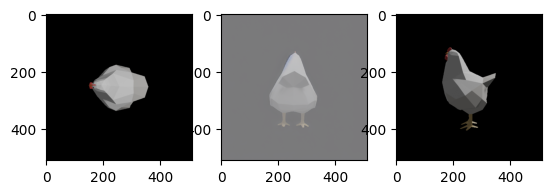

In [75]:
plot_images(cond_image,pred_image,target_image) #SEED = 12 guifdance = 7

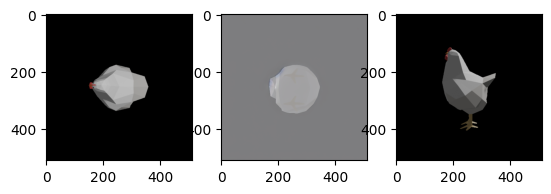

In [79]:
plot_images(cond_image,pred_image,target_image) #SEED = 12567 guidance = 7

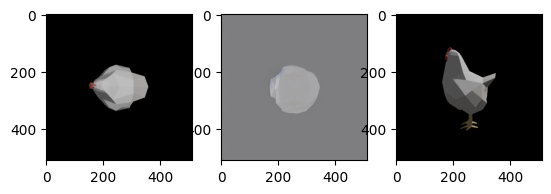

In [81]:
plot_images(cond_image,pred_image,target_image) #SEED = 12567 guidance = 0

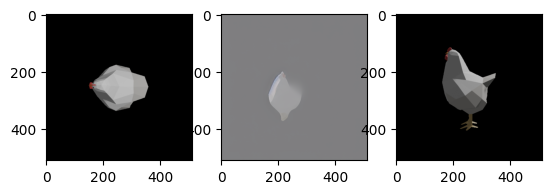

In [92]:
plot_images(cond_image,pred_image,target_image) #random camera matrix times 10

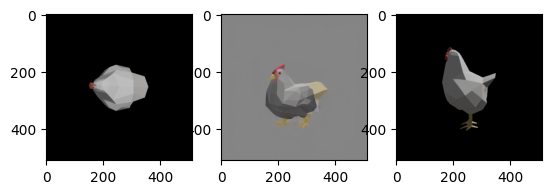

In [90]:
plot_images(cond_image,pred_image,target_image) #random camera matrix times 10

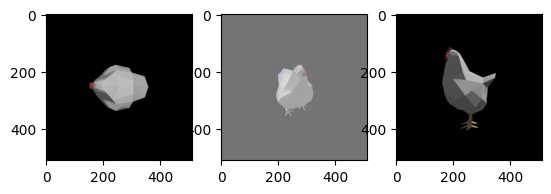

In [94]:
plot_images(cond_image,pred_image,target_image) #random camera matrix times 10

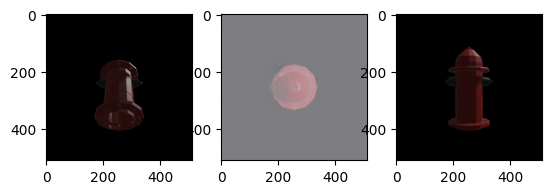

In [108]:
plot_images(cond_image,pred_image,target_image) #seed 

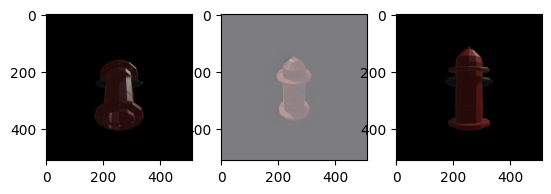

In [112]:
plot_images(cond_image,pred_image,target_image) #seed

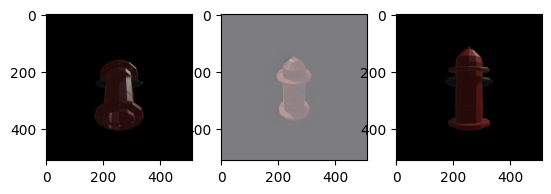

In [117]:
plot_images(cond_image,pred_image,target_image) #with random camera

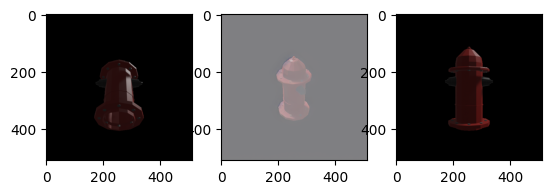

In [120]:
plot_images(cond_image,pred_image,target_image) #with random camera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1299.366..1249.9261].


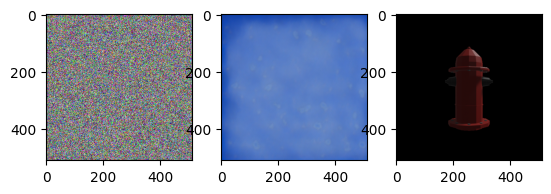

In [124]:
plot_images(random_cond_image,pred_image,target_image) #with random camera

In [ ]:
def print_parameter_statistics(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Statistics for {name}:")
            param_data = param.data
            mean = param_data.mean().item()
            std_dev = param_data.std().item()
            param_min = param_data.min().item()
            param_max = param_data.max().item()
            print(f"  Mean: {mean}")
            print(f"  Std Dev: {std_dev}")
            print(f"  Min: {param_min}")
            print(f"  Max: {param_max}")
            print()

# Print statistics for the model parameters
print_parameter_statistics(camera_encoder)

Statistics for lin1.weight:
  Mean: 0.016168540343642235
  Std Dev: 0.1677769273519516
  Min: -0.28651952743530273
  Max: 0.2942749857902527

Statistics for lin1.bias:
  Mean: 0.013618184253573418
  Std Dev: 0.16840581595897675
  Min: -0.24139373004436493
  Max: 0.26740431785583496

Statistics for transposed_convs.0.weight:
  Mean: 0.04380388185381889
  Std Dev: 0.1448410302400589
  Min: -0.23967963457107544
  Max: 0.2306160032749176

Statistics for transposed_convs.0.bias:
  Mean: 0.17334240674972534
  Std Dev: nan
  Min: 0.17334240674972534
  Max: 0.17334240674972534

Statistics for transposed_convs.1.weight:
  Mean: -0.0010389273520559072
  Std Dev: 0.09175042808055878
  Min: -0.19448931515216827
  Max: 0.18339015543460846

Statistics for transposed_convs.1.bias:
  Mean: 0.050113655626773834
  Std Dev: 0.047577276825904846
  Min: -0.003897204762324691
  Max: 0.11105984449386597

Statistics for convs.0.weight:
  Mean: -0.06188894808292389
  Std Dev: 0.18565139174461365
  Min: -0.3980

<ipython-input-274-54a7af26c2a8>:7: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std_dev = param_data.std().item()


In [ ]:
print_parameter_statistics(controlnet)

Statistics for conv_in.weight:
  Mean: 0.00015081444871611893
  Std Dev: 0.05870194360613823
  Min: -0.34009575843811035
  Max: 0.3862171173095703

Statistics for conv_in.bias:
  Mean: 0.004705347120761871
  Std Dev: 0.07444902509450912
  Min: -0.15912503004074097
  Max: 0.21664613485336304

Statistics for time_embedding.linear_1.weight:
  Mean: -0.0011874550255015492
  Std Dev: 0.014763940125703812
  Min: -0.2378397136926651
  Max: 0.18423864245414734

Statistics for time_embedding.linear_1.bias:
  Mean: -0.0036138419527560472
  Std Dev: 0.019918475300073624
  Min: -0.13936880230903625
  Max: 0.04107240214943886

Statistics for time_embedding.linear_2.weight:
  Mean: -1.947701457538642e-05
  Std Dev: 0.0023078033700585365
  Min: -0.31207889318466187
  Max: 0.16693300008773804

Statistics for time_embedding.linear_2.bias:
  Mean: -0.00013304525054991245
  Std Dev: 0.006325254682451487
  Min: -0.02424321137368679
  Max: 0.06981046497821808

Statistics for controlnet_cond_embedding.conv_

### TEST everything of the loop is ok

In [ ]:
batch = next(iter(train_dl))

In [ ]:
cond_image = batch["input_imgs"][0].to(device='cuda')[None,:]
camera = batch['camera'][0].to(device='cuda')[None,:]
target_image = batch['rotated_imgs'][0].to(device='cuda')[None,:]
tokenized_prompt = batch['texts'][0].to(device='cuda')[None,:]

In [ ]:
target_image

tensor([[[0.0000, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.

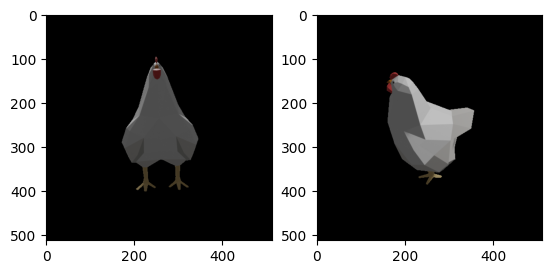

In [ ]:
plot_images(cond_image, target_image)

In [ ]:
text_encoder(tokenized_prompt[None,:], attention_mask = None, return_dict= False)

(tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [ 0.8511, -0.5896,  0.9544,  ..., -0.6533,  0.6332,  0.0719],
          [-1.0283,  1.1159,  0.5779,  ..., -0.8676, -0.9100,  0.8129],
          ...,
          [ 0.1782,  0.5440,  0.8598,  ...,  0.6385, -0.2484, -0.0639],
          [ 0.1675,  0.5403,  0.8832,  ...,  0.6285, -0.2368, -0.0552],
          [ 0.2285,  0.5589,  0.9154,  ...,  0.5462, -0.2110, -0.1172]]],
        device='cuda:0', grad_fn=<NativeLayerNormBackward0>),
 tensor([[ 3.2388e-01,  7.3608e-01,  8.1907e-01,  4.3601e-01, -2.7232e+00,
           5.0591e-01, -1.3198e+00,  1.9284e+00,  1.2081e+00, -1.6028e-01,
          -9.4273e-01,  8.4401e-01, -1.8576e-01,  8.0993e-01, -2.5517e-01,
           9.6256e-02,  6.1784e-01,  1.5724e+00,  1.7635e+00,  3.0291e+00,
           3.5519e-01, -6.3348e-01, -1.9192e+00, -2.3522e+00,  1.2672e+00,
           2.2991e-01, -1.1147e+00, -1.4649e+00, -1.6624e+00,  4.1248e-01,
          -1.4253e+00,  8.4083e-01, -5.

In [ ]:
cond_image.min()

tensor(0., device='cuda:0')

In [ ]:
pred_image.min()

tensor(-1.1707, device='cuda:0')

In [ ]:
generator = torch.manual_seed(SEED).to(device=device)
generator

AttributeError: 'torch._C.Generator' object has no attribute 'to'

In [ ]:
generator = torch.Generator(device=device)
generator.manual_seed(SEED)
print(SEED)

3785279


In [ ]:
for i in range(10):
  print(torch.randn((1, 2), device=device, generator=generator))

tensor([[-0.1203, -0.2804]], device='cuda:0')
tensor([[-1.6111, -0.7336]], device='cuda:0')
tensor([[-0.5470,  1.1741]], device='cuda:0')
tensor([[0.1007, 1.7760]], device='cuda:0')
tensor([[ 0.7681, -0.1351]], device='cuda:0')
tensor([[ 0.8871, -1.3796]], device='cuda:0')
tensor([[ 0.0314, -0.5985]], device='cuda:0')
tensor([[-0.4627, -0.4749]], device='cuda:0')
tensor([[ 0.2797, -0.0637]], device='cuda:0')
tensor([[0.3219, 0.7333]], device='cuda:0')


In [ ]:
for i in range(10):
  print(torch.randn((1, 2), device=device, generator=generator))

tensor([[-0.1203, -0.2804]], device='cuda:0')
tensor([[-1.6111, -0.7336]], device='cuda:0')
tensor([[-0.5470,  1.1741]], device='cuda:0')
tensor([[0.1007, 1.7760]], device='cuda:0')
tensor([[ 0.7681, -0.1351]], device='cuda:0')
tensor([[ 0.8871, -1.3796]], device='cuda:0')
tensor([[ 0.0314, -0.5985]], device='cuda:0')
tensor([[-0.4627, -0.4749]], device='cuda:0')
tensor([[ 0.2797, -0.0637]], device='cuda:0')
tensor([[0.3219, 0.7333]], device='cuda:0')


#VERY USEFUL LINKS!
https://github.com/huggingface/diffusers/tree/main?tab=readme-ov-file

https://huggingface.co/docs/diffusers/training/overview

https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet.py#L1149   !! VERY IMPORTANT!! Check the train loop!!

https://huggingface.co/docs/accelerate/en/usage_guides/explore (Accelerate)

Reminder eugenio:

https://huggingface.co/docs/diffusers/tutorials/basic_training  (train diffusion model, you stopped here)